### This script contains all the codes to repoduce main and extended data figures in the manuscript.

In [2]:
import os
import sys
import glob2
import itertools
import string
import warnings

# data handling and statistics
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from scipy import cluster
from scipy.cluster import hierarchy
from scikit_posthocs import posthoc_tukey

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import matplotlib.font_manager
from PIL import Image
from matplotlib.ticker import FormatStrFormatter
from matplotlib_venn import venn3
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from statannotations.Annotator import Annotator
from matplotlib.colors import ListedColormap

### 0. Housekeeping

In [3]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
os.getcwd()

'/Users/yiqiao/Desktop/CRXHD_mousemodel'

In [5]:
# set the parent directory as the working directory
# compatible naming between WinOS and MacOS
base_dir = os.getcwd()
sys.path.insert(0, os.path.join(os.getcwd(),"utils"))

In [6]:
from utils import specseq_ewm_utils, specseq_plot_utils, chip_rna_annotator, chipseq_plot_utils, rnaseq_plot_utils
specseq_plot_utils.set_manuscript_params()

Fontconfig warning: ignoring UTF-8: not a valid region tag


In [7]:
# set up directory variables
# Specseq data
spec_basedir = os.path.join(base_dir, "Specseq_analysis", "processed_data")
RBE_dir = os.path.join(spec_basedir, "RBE")
# CRX ChIP data
chip_basedir = os.path.join(base_dir,"ChIPseq_analysis","processed_data")
# CRX RNA data
rna_basedir = os.path.join(base_dir,"RNAseq_analysis","processed_data")
# Aldiri RNA data
devrna_dir = os.path.join(base_dir,"RNAseq_analysis","processed_data")
# luciferase data
luc_dir = os.path.join(base_dir,"luciferase")
# figure output directory
outbase_dir = os.path.join(base_dir, "Figures")

In [8]:
# initialize color palettes
# heatmap color scheme
div_heat_colors = mpl.colors.LinearSegmentedColormap.from_list(
                        "yq_divergent", [(0, "#CF8B03"), (0.5, "#FFFFFF"), (1, "#08306B")])
single_heat_colors = mpl.colors.LinearSegmentedColormap.from_list(
                        "yq_single", [(0, "#D5DCE6"), (1, "#08306B")])
                        
# label name helper lists
peak_order = ["e80a_shared","k88n_unique"]
pretty_names = pd.Series({"ehet":"E80A/+", "ehom":"E80A/A","khet":"K88N/+","khom":"K88N/N", "rhom":"R90W/W", "wthom":"WT"})

delta_unicode = "\u0394"

aldiri_refNum=str(39)

### read data

In [9]:
# Specseq
# raw RBE data
spec_protein_list = ["wt","e80a","r90w","k88n"]
RBEfile_ser = {}
sample_labels = {}
for p,d in zip(spec_protein_list,[RBE_dir]*len(spec_protein_list)):
    file_list = sorted(glob2.glob(os.path.join(d, p + "*.txt")))
    # read in all RBE files input a tuple, should follow replicate number
    RBEfile_ser[p] = list(pd.read_csv(f, header=0, sep='\t',index_col=0).squeeze("columns") for f in file_list)
    sample_labels[p] = tuple(os.path.split(file_list[i])[1].split("_RBE.txt")[0] for i in range(len(file_list)))
RBEfile_ser = pd.Series(RBEfile_ser)
# check the number of available dataset for each protein
print("Imported dataset label names (inferred):")
display(pd.DataFrame.from_dict({k:v for k,v in sample_labels.items()}, orient='index'))

# average RBE data
RBE_filelist=list(glob2.glob(os.path.join(RBE_dir,"avgRBE","*_avgRBE.txt")))
all_energy_matrix = {os.path.split(RBE_filelist[i])[1].split("_avgRBE.txt")[0]:pd.read_csv(RBE_filelist[i], sep="\t", header=0) for i in range(len(RBE_filelist))}
# convert to series
all_energy_matrix = pd.Series(all_energy_matrix)

# energy models (ewm)
all_energy_model = specseq_ewm_utils.read_ewm_files(os.path.join(spec_basedir, "specseq_ewm_sklearn.txt"))

Imported dataset label names (inferred):


,0,1
wt,wt_1,wt_2
e80a,e80a_1,e80a_2
r90w,r90w_1,r90w_2
k88n,k88n_1,k88n_2


reading ewm for wt.M.m
reading ewm for wt.Mrev.m
reading ewm for e80a.M.m
reading ewm for e80a.Mrev.m
reading ewm for k88n.M.m
reading ewm for k88n.Mrev.m
reading ewm for r90w.M.m
reading ewm for r90w.Mrev.m


In [10]:
# RNAseq in the current study
# compiled expression level and differential expression analysis results tables
rna_compiled_counts = pd.read_csv(os.path.join(rna_basedir, "collapsed_norm_counts.tsv"), sep="\t", header=0)
rna_compiled_lfc = pd.read_csv(os.path.join(rna_basedir,"compiled_hdmuts_lfc.tsv"), sep="\t", header=0).rename(columns={"GENENAME":"gene"})

# Genelist with annotation of CRX-dependency 
crx_dependent_gene = pd.read_csv(os.path.join(rna_basedir, "crx_dependent_genes.tsv"), sep="\t", header=0)

# RNAseq from Aldiri 2017
aldiri_norm_counts =  pd.read_csv(os.path.join(rna_basedir, "aldiri_normalized_counts.tsv"), sep="\t", header=0)
mask = aldiri_norm_counts.iloc[:,2:]>=1
clean_aldiri = aldiri_norm_counts[mask.sum(axis=1) == len(mask.columns)].reset_index(drop=True).iloc[:,1:].set_index("gene")
clean_aldiri_rowz = scipy.stats.zscore(clean_aldiri.iloc[:,3:], axis=1) # use only postnatal ages for normalization

In [11]:
# CRX ChIPseq
# compiled binding intensity and differential binding analysis results table
chip_full_matrix = pd.read_csv(os.path.join(chip_basedir, "hdmuts_chip_compiled_matrix.tsv"), sep="\t", header=0)

# motif models from MEME-ChIP
hdmuts_meme_pwms = specseq_ewm_utils.read_meme_files(os.path.join(chip_basedir,"all_chip_pwm.meme"))
hdmuts_meme_stats = pd.Series({
    "wt_olap.DREME.1": "4.7e-369",
    "e80a_olap.DREME.1": "4.0e-689",
    "k88n_olap.DREME.1": "2.2e-085",
})

# GREAT analysis output table
great_map = pd.read_csv(os.path.join(chip_basedir, "hdmuts_chip_all_regions_great_gene.tsv"), sep="\t", header=0)

# HOMER genomic region annotation table
homer_annot = pd.read_csv(os.path.join(chip_basedir, "hdmuts_chip_all_regions_annotation.parsed.tsv"), sep="\t", header=0)

reading pwm for wt_olap.DREME.1
reading pwm for e80a_olap.DREME.1
reading pwm for k88n_olap.DREME.1
reading pwm for NRL.MA0842.2
reading pwm for Crx.MA0467.1


### I. Spec-seq

In [12]:
def merge_paired_energy_data(data1, data2, lib, band, labels):
    band = data1.columns[data1.columns.str.contains(band)]
    merged_df = pd.merge(data1.loc[lambda df: df.lib==lib, band], data2.loc[lambda df: df.lib==lib, band], left_index=True, right_index=True)
    merged_df.columns = labels # give it axis labels
    merged_df = pd.merge(data1.MMcount,merged_df,left_index=True,right_index=True)

    return merged_df

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


mean difference in ΔΔG for wt replicates is 0.114kT
mean difference in ΔΔG between r90w and wt is 0.511kT
mean difference in ΔΔG between e80a and wt is 0.335kT
mean difference in ΔΔG between k88n and wt is 0.921kT


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


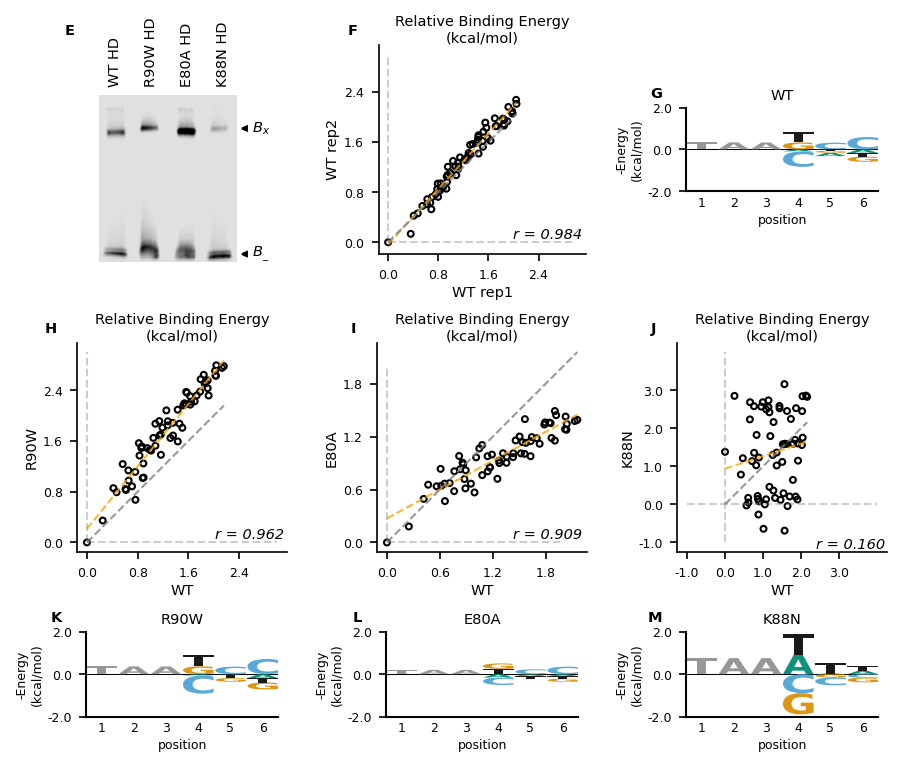

In [36]:
# Fig.2 M library Spec-seq

# Set up the figure
fig = plt.figure(figsize=(6,5), constrained_layout=True, dpi=150)
gs = fig.add_gridspec(nrows=3, ncols=3, width_ratios=[1,1,1], height_ratios=[1,1,.45])
gs.update(left=0.05,right=0.95,top=0.95,bottom=0.05,wspace=0.0,hspace=0.05)

find_lib = "M"
find_band = "M.mddG"

# Panel c. EMSA gel image
# create a dummy axes for the top left corner space
ax = fig.add_subplot(gs[0, 0])
ax.set_frame_on(False)
ax.set_axis_off()
# insert a child axes and draw image in the child axes
axin = ax.inset_axes([0.14,-0.04,0.6,0.8],transform=ax.transAxes)
# insert the gel image
axin.imshow(plt.imread(os.path.join(spec_basedir, "EMSA_gelimage.png"), format='png'))
axin.axis('off')
# add labels
ax.text(0.22, 0.8, "WT HD", rotation=90, va='bottom', ha='center', transform=ax.transAxes, fontsize=mpl.rcParams["axes.labelsize"], zorder=2)
ax.text(0.37, 0.8, "R90W HD", rotation=90, va='bottom', ha='center', transform=ax.transAxes, fontsize=mpl.rcParams["axes.labelsize"], zorder=2)
ax.text(0.52, 0.8, "E80A HD", rotation=90, va='bottom', ha='center', transform=ax.transAxes, fontsize=mpl.rcParams["axes.labelsize"], zorder=2)
ax.text(0.67, 0.8, "K88N HD", rotation=90, va='bottom', ha='center', transform=ax.transAxes, fontsize=mpl.rcParams["axes.labelsize"], zorder=2)
# add band labels
ax.text(0.79, 0.00, r"$\itB_{\_}$", va='center', ha='left', transform=ax.transAxes, fontsize=mpl.rcParams["axes.labelsize"], zorder=4)
ax.text(0.79, 0.60, r"$\itB_{x}$", va='center', ha='left', transform=ax.transAxes, fontsize=mpl.rcParams["axes.labelsize"], zorder=4)
triangle_pos = np.array([[0.77,0.61], [0.77,0.59], [0.75,0.60], [0.77,-0.01], [0.77,0.01], [0.75,0.00]])
ax.add_patch(mpatches.Polygon(triangle_pos[:3,:], color="k", transform=ax.transAxes, clip_on = False, zorder=4))
ax.add_patch(mpatches.Polygon(triangle_pos[3:6,:], color="k", transform=ax.transAxes, clip_on = False, zorder=4))

# Panel d. wt replicate correlation
ax = fig.add_subplot(gs[0, 1])
# merge RBE data from two replicates of WT HD
wt_M_m_df = merge_paired_energy_data(RBEfile_ser["wt"][0],RBEfile_ser["wt"][1],find_lib,find_band,labels=["wt_1", "wt_2"])
# what is returned: text = (f'r = {pearson_corr:.3f}', f'\u03C1 = {spearman_corr:.3f}', slope, intercept, mean_diffRBE)
fig, ax, text = specseq_plot_utils.make_correlation_scatter(wt_M_m_df, ["wt_1", "wt_2"], lr=True, colors="black",
                                        xticks=None, yticks=None, stepsize=0.8, figax=(fig,ax))
# add PCC to the bottom right corner
left,right = ax.get_xlim()
bottom, top = ax.get_ylim()
if bottom > -0.4:
    bottom = 0
ax.text(right-0.05, bottom+0.01, text[0], fontsize=mpl.rcParams["axes.labelsize"], horizontalalignment='right', verticalalignment='bottom', style = 'italic') # PCC
#ax.text(right-0.05, bottom+0.01, text[1], fontsize=mpl.rcParams["axes.labelsize"], horizontalalignment='right', verticalalignment='bottom', style = 'italic') # SCC

ax.set_title("Relative Binding Energy\n(kcal/mol)", va="bottom", pad=0)
print(f"mean difference in {delta_unicode}{delta_unicode}G for wt replicates is {text[4]:.3f}kT")

# Panel e. wt energy model
ax = fig.add_subplot(gs[0, 2])
ax.axis("off")
axin = ax.inset_axes([.1,.3,.8,.4],transform=ax.transAxes)
fig, axin, ewm_logo = specseq_plot_utils.make_ewm_logo(all_energy_model["wt.M.m"], sequence_design="TAANNN", add_filler=True, x_label=True, figax=(fig,axin))
axin.set_title("wt".upper())
axin.set_ylim(-2,2)

# Panel f-h. the middle rows are three mut v.s. wt correlation scatters
for i,(p,stps) in enumerate(zip(["r90w","e80a","k88n"], [0.8,0.6,1.0])):
    ax = fig.add_subplot(gs[1, i])
    mut_M_m_df = merge_paired_energy_data(all_energy_matrix["wt"],all_energy_matrix[p],find_lib,find_band,["wt", p])
    # correlation scatter plot
    fig, ax, text = specseq_plot_utils.make_correlation_scatter(mut_M_m_df, ["wt", p],  lr=True, colors="black", 
                                            xticks=None, yticks=None, stepsize=stps, figax=(fig,ax))
    left,right = ax.get_xlim()
    bottom, top = ax.get_ylim()
    if bottom > -0.4:
        bottom = 0
    ax.text(right-0.05, bottom+0.01, text[0], fontsize=mpl.rcParams["axes.labelsize"], horizontalalignment='right', verticalalignment='bottom', style = 'italic') # PCC
    #ax.text(right-0.05, bottom+0.01, text[1], fontsize=mpl.rcParams["axes.labelsize"], horizontalalignment='right', verticalalignment='bottom', style = 'italic') # SCC
    print(f"mean difference in {delta_unicode}{delta_unicode}G between {p} and wt is {text[4]:.3f}kT")
    ax.set_title("Relative Binding Energy\n(kcal/mol)", va="bottom", pad=0)

# Panel i-k. mutant ewm models at the bottom
for i,(p,coord) in enumerate(zip(["r90w","e80a","k88n"],((2,0),(2,1),(2,2)))):
    ax = fig.add_subplot(gs[coord[0], coord[1]])
    ax.axis("off")
    # add child axes and plot the ewm there
    axin = ax.inset_axes([.1,0,.8,.9],transform=ax.transAxes)
    fig, axin, ewm_logo = specseq_plot_utils.make_ewm_logo(all_energy_model[p+".M.m"], sequence_design="TAANNN", add_filler=True, x_label=True, figax=(fig,axin))
    axin.set_title(p.upper()) # add protein name as title
    axin.set_ylim(-2,2)

# add the panel letters
for i,ax in enumerate(fig.get_axes()):
    label = string.ascii_uppercase[i+4]
    if i == 0: # gel image
        specseq_plot_utils.add_letter(ax, 0.05, 1.1, label)
    elif i == 2: # wt energy model
        specseq_plot_utils.add_letter(ax, 0, .8, label)
        ax.set_ylabel("-Energy\n(kcal/mol)")
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    elif i in [1,3,4,5]: # scatter plots
        specseq_plot_utils.add_letter(ax, -0.1, 1.1, label)
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    else: # energy models
        specseq_plot_utils.add_letter(ax, 0, 1.13, label)
        ax.set_ylabel("-Energy\n(kcal/mol)")
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))


In [37]:
specseq_plot_utils.save_fig(fig, prefix=os.path.join(outbase_dir, "manuscript", "figure2_specseq"), timestamp=False, tight_layout=False)

mean difference in ΔΔG for r90w replicates is 0.133kT
mean difference in ΔΔG for e80a replicates is 0.125kT
mean difference in ΔΔG for k88n replicates is 0.145kT
mean difference in ΔΔG for wt replicates is 0.192kT
mean difference in ΔΔG for r90w replicates is 0.096kT
mean difference in ΔΔG for e80a replicates is 0.123kT
mean difference in ΔΔG for k88n replicates is 0.141kT


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


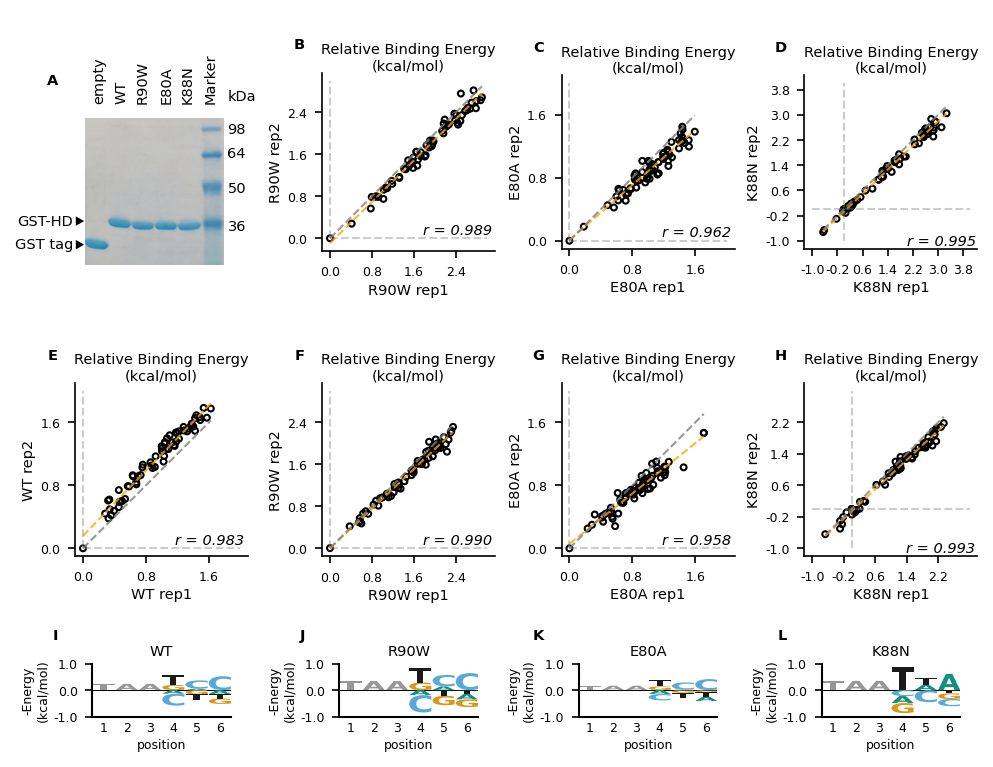

In [11]:
# Specseq extended data Fig.1
# set up the figure
fig, ax_list = plt.subplots(ncols=4, nrows=3, figsize=(6.5,5), dpi=150, constrained_layout=True, 
                            gridspec_kw=dict(width_ratios=[1,1,1,1], height_ratios=[2,2,.4],
                             left=0.05,right=0.95,top=0.95,bottom=0.05,wspace=0.0, hspace=0.05))
ax_list = ax_list.flatten()

# Panel a. SDS-PAGE gel image
# add a dummy label for the image panel
ax = ax_list[0]
ax.set_frame_on(False)
ax.set_axis_off()
# insert a child axes and draw image in the child axes
axin = ax.inset_axes([0.06,0.0,0.8,0.8],transform=ax.transAxes)
# insert the gel image
axin.imshow(plt.imread(os.path.join(spec_basedir, "SDSPAGE_gelimage.png"), format='png'), zorder=1)
axin.axis('off')
# add labels
bottom = .7
ax.text(0.14, bottom, "empty", rotation=90, va='bottom', ha='center', transform=ax.transAxes, fontsize=mpl.rcParams["axes.labelsize"], zorder=5)
ax.text(0.27, bottom, "WT", rotation=90, va='bottom', ha='center', transform=ax.transAxes, fontsize=mpl.rcParams["axes.labelsize"], zorder=5)
ax.text(0.39, bottom, "R90W", rotation=90, va='bottom', ha='center', transform=ax.transAxes, fontsize=mpl.rcParams["axes.labelsize"], zorder=5)
ax.text(0.53, bottom, "E80A", rotation=90, va='bottom', ha='center', transform=ax.transAxes, fontsize=mpl.rcParams["axes.labelsize"], zorder=5)
ax.text(0.65, bottom, "K88N", rotation=90, va='bottom', ha='center', transform=ax.transAxes, fontsize=mpl.rcParams["axes.labelsize"], zorder=5)
ax.text(0.78, bottom, "Marker", rotation=90, va='bottom', ha='center', transform=ax.transAxes, fontsize=mpl.rcParams["axes.labelsize"], zorder=2)

# add band labels on the left
ax.text(-.01, 0.30, "GST-HD", va='center', ha='right', transform=ax.transAxes, fontsize=mpl.rcParams["axes.labelsize"], zorder=4)
ax.text(-.01, 0.22, "GST tag", va='center', ha='right', transform=ax.transAxes, fontsize=mpl.rcParams["axes.labelsize"], zorder=4)
triangle_pos = np.array([[0.01,0.31], [0.01,0.29], [0.04,0.30], [0.01,0.23], [0.01,0.21], [0.04,0.22]])
ax.add_patch(mpatches.Polygon(triangle_pos[:3,:], color="k", transform=ax.transAxes, clip_on = False, zorder=4))
ax.add_patch(mpatches.Polygon(triangle_pos[3:6,:], color="k", transform=ax.transAxes, clip_on = False, zorder=4))

# add molecular markers on the right
left = 0.88
ax.text(left, 0.28, "36", va='center', ha='left', transform=ax.transAxes, fontsize=mpl.rcParams["axes.labelsize"], zorder=4)
ax.text(left, 0.41, "50", va='center', ha='left', transform=ax.transAxes, fontsize=mpl.rcParams["axes.labelsize"], zorder=4)
ax.text(left, 0.53, "64", va='center', ha='left', transform=ax.transAxes, fontsize=mpl.rcParams["axes.labelsize"], zorder=4)
ax.text(left, 0.61, "98", va='center', ha='left', transform=ax.transAxes, fontsize=mpl.rcParams["axes.labelsize"], zorder=4)
ax.text(left, 0.70, "kDa", va='bottom', ha='left', transform=ax.transAxes, fontsize=mpl.rcParams["axes.labelsize"], zorder=4)

# add the subplot letter
specseq_plot_utils.add_letter(ax, -0.1, 0.8, "A")


# Panel b-d. first row: M library replicate correlation
find_lib = "M"
find_band = "M.mddG"

for i,p in enumerate(["r90w","e80a","k88n"]):
    M_m_df = merge_paired_energy_data(RBEfile_ser[p][0],RBEfile_ser[p][1],find_lib,find_band,[f"{p}_1", f"{p}_2"])
    ax = ax_list[i+1]
    # text = (f'r = {pearson_corr:.3f}', f'\u03C1 = {spearman_corr:.3f}', slope, intercept, mean_diffRBE)
    fig, ax, text = specseq_plot_utils.make_correlation_scatter(M_m_df, [f"{p}_1", f"{p}_2"], lr=True, colors="black",
                                            xticks=None, yticks=None, stepsize=0.8, figax=(fig,ax))
    # add PCC to the bottom right corner
    left,right = ax.get_xlim()
    bottom, top = ax.get_ylim()
    if bottom > -0.4:
        bottom = 0
    ax.text(right-0.05, bottom+0.01, text[0], fontsize=mpl.rcParams["axes.labelsize"], horizontalalignment='right', verticalalignment='bottom', style = 'italic') # PCC
    #ax.text(right-0.05, bottom+0.01, text[1], fontsize=mpl.rcParams["axes.labelsize"], horizontalalignment='right', verticalalignment='bottom', style = 'italic') # SCC
    ax.set_title("Relative Binding Energy\n(kcal/mol)", va="bottom", pad=0)
    print(f"mean difference in {delta_unicode}{delta_unicode}G for {p} replicates is {text[4]:.3f}kT")

# add the subplot letters
for i,ax in enumerate(ax_list[1:4]):
    label = string.ascii_uppercase[i+1]
    specseq_plot_utils.add_letter(ax, -0.1, 1.2, label)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

# Panel e-h. second row: M reverse library replicate correlation
find_lib = "Mrev"
find_band = "Mrev.mddG"

for i,p in enumerate(["wt","r90w","e80a","k88n"]):
    M_m_df = merge_paired_energy_data(RBEfile_ser[p][0],RBEfile_ser[p][1],find_lib,find_band,[f"{p}_1", f"{p}_2"])
    ax = ax_list[i+4]
    # text = (f'r = {pearson_corr:.3f}', f'\u03C1 = {spearman_corr:.3f}', slope, intercept, mean_diffRBE)
    fig, ax, text = specseq_plot_utils.make_correlation_scatter(M_m_df, [f"{p}_1", f"{p}_2"], lr=True, colors="black",
                                            xticks=None, yticks=None, stepsize=0.8, figax=(fig,ax))
    # add PCC to the bottom right corner
    left,right = ax.get_xlim()
    bottom, top = ax.get_ylim()
    if bottom > -0.4:
        bottom = 0
    ax.text(right-0.05, bottom+0.01, text[0], fontsize=mpl.rcParams["axes.labelsize"], horizontalalignment='right', verticalalignment='bottom', style = 'italic') # PCC
    #ax.text(right-0.05, bottom+0.01, text[1], fontsize=mpl.rcParams["axes.labelsize"], horizontalalignment='right', verticalalignment='bottom', style = 'italic') # SCC
    #ax.set_title("$\Delta \Delta G$ (kcal/mol)")
    ax.set_title("Relative Binding Energy\n(kcal/mol)", va="bottom", pad=0)
    print(f"mean difference in {delta_unicode}{delta_unicode}G for {p} replicates is {text[4]:.3f}kT")

# add the subplot letters
for i,ax in enumerate(ax_list[4:8]):
    label = string.ascii_uppercase[i+4]
    specseq_plot_utils.add_letter(ax, -0.1, 1.2, label)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

# Panel i-l. last row: M reverse library EWMs
for i,p in enumerate(["wt","r90w","e80a","k88n"]):
    ax = ax_list[i+8]
    ax.axis("off")
    # add child axes and plot the ewm there
    axin = ax.inset_axes([.1,0,.8,.9],transform=ax.transAxes)
    # HD site is at reverseed complement position
    ewm = specseq_ewm_utils.get_motif_revcomp(all_energy_model[p+".Mrev.m"]).copy() 
    # Once we reverse complement the matrix we also need to adjust the index positions
    ewm.index.name = "pos"
    ewm.index = range(4, len(ewm.index)+4, 1)
    fig, axin, ewm_logo = specseq_plot_utils.make_ewm_logo(ewm, sequence_design="TAANNN", add_filler=True, x_label=True, figax=(fig,axin))
    axin.set_title(p.upper()) # add protein name as title
    axin.set_ylim(-1,1)

# add the panels letters
for i,ax in enumerate(ax_list[8:12]):
    label = string.ascii_uppercase[i+8]
    specseq_plot_utils.add_letter(ax, -.1, 1.5, label)
    ax.set_ylabel("-Energy\n(kcal/mol)")
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

In [12]:
specseq_plot_utils.save_fig(fig, prefix=os.path.join(outbase_dir, "extended", "extended.figure1_specseq"), timestamp=False, tight_layout=False)

### II. ChIP-seq

#### CRX peak cluster identification and assignment

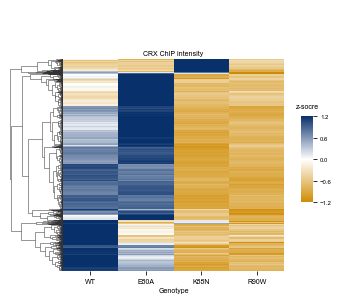

In [15]:
intensity_df = chip_full_matrix.loc[:,["WT","E80A","K88N","R90W"]].copy()

chip_heatmap = chipseq_plot_utils.chip_intensity_heatmap(intensity_df, hm_title="CRX ChIP intensity", hm_xlabel="Genotype", cb_title="z-socre",
                paramdict = { # put any seaborn clustermap parameters to update here
                        'figsize': (4,4),
                        'cbar_pos': (1.04, .3, .04, .3),
                        'vmin': -1.2, 
                        'vmax': 1.2,
                        'cbar_kws': {'ticks': [-1.2,-0.6,0,0.6,1.2]}
                })

 # to display the row dendrogram
chip_heatmap.ax_row_dendrogram.set_visible(True)

In [16]:
# retrieve cluster assignment
# cut the linkage matrix at the second level to assign peaks to cluster1 or 2
Z = chip_heatmap.dendrogram_row.linkage
cutree = cluster.hierarchy.cut_tree(Z, n_clusters=2)

crxPeak_annot_df = pd.DataFrame(cutree, columns={"cluster"})
crxPeak_annot_df[["cluster"]] = crxPeak_annot_df[["cluster"]].mask(crxPeak_annot_df[["cluster"]] == 0, 'Cluster1', inplace=False)
crxPeak_annot_df[["cluster"]] = crxPeak_annot_df[["cluster"]].mask(crxPeak_annot_df[["cluster"]] == 1, 'Cluster2', inplace=False)

# append to the lfc matrix and reorder the dataframe as in the expression heatmap
new_order = chip_heatmap.dendrogram_row.reordered_ind
reordered_chip_int_matrix = pd.concat([chip_full_matrix, crxPeak_annot_df], axis=1, ignore_index=False).iloc[new_order,:].reset_index(drop=True)
del(crxPeak_annot_df)

# check the number of genes assigned to cluster1 or 2
display(reordered_chip_int_matrix.cluster.value_counts())

Cluster1    9165
Cluster2     656
Name: cluster, dtype: int64

In [17]:
# save the dataframe
reordered_chip_int_matrix.to_csv(os.path.join(chip_basedir, "clustered_peakset", "scaled_clustered_chip_regions.tsv"), sep="\t", na_rep="NaN", index=False)

# save two bed files for each cluster
for gp in ["Cluster1", "Cluster2"]:
    tmp = reordered_chip_int_matrix.loc[lambda df: df.cluster==gp,:].iloc[:,1:4].copy().sort_values(["seqnames", "start"], ascending = (True, True))
    #tmp.to_csv(os.path.join(chip_basedir, "clustered_peakset", f"{gp}_regions.bed"), sep="\t", index=False, header=False)

# update the chip matrix
chip_full_matrix = reordered_chip_int_matrix.copy()
del (reordered_chip_int_matrix)

/tmp/ipykernel_2517/3790305657.py:30: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((int(width), int(height)), Image.ANTIALIAS)


(0.0, 1.0, 0.0, 1.0)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


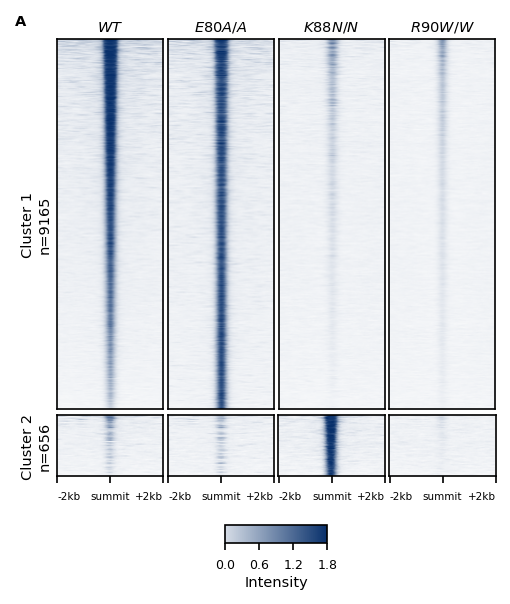

In [12]:
# Panel 3a. binding intensity heatmap, modified from deeptools heatmap
# set up the figure
fig = plt.figure(figsize=(3.4,4), dpi=150) #constrained_layout=True, 
gs = fig.add_gridspec(nrows=4, ncols=5, width_ratios=[.15,1,1,1,1], height_ratios=[.1,6,1,.4])
gs.update(left=.05,right=.95,top=.9,bottom=.1,wspace=0.05,hspace=0.05) #padding for each grid space

peak_order = ["cluster1","cluster2"]
peak_num = [9165,656]
labels = ["WT", "E80A/A", "K88N/N", "R90W/W"]
for i,peak, in enumerate(peak_order):
    # first add the cluster label
    text_ax = fig.add_subplot(gs[i+1, 0])
    text_ax.set_frame_on(False)
    text_ax.set_axis_off()
    text_ax.text(0, .5, f"Cluster {str(i+1)}\nn={str(peak_num[i])}", rotation=90, fontsize=mpl.rcParams["axes.labelsize"], va='center', ha='center')
    for j in range(4):
        ax = fig.add_subplot(gs[i+1, j+1])
        ax.set_frame_on(True)
        # add genotype label
        if i== 0:
            ax.set_title(f"$\it{labels[j]}$")
        # read the heatmap image
        img = Image.open(os.path.join(chip_basedir, "hdmuts_intensity_heatmaps", peak+"."+str(j)+".png"))
        # get the width and height of axes box
        bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        width, height = bbox.width, bbox.height
        width *= fig.dpi
        height *= fig.dpi
        # resize image
        img = img.resize((int(width), int(height)), Image.ANTIALIAS)
        ax.imshow(img, origin='upper')
        if i < 1: # remove axis and frame if not the bottom row of heatmap
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
        else: # add the dist to submit labels
            ax.yaxis.set_visible(False) # hide y axis
            ax.spines.bottom.set_visible(True)
            ax.xaxis.set_ticks_position('bottom')
            ax.set_xticks([0,int(width)/2,int(width)])
            ax.set_xticklabels(["-2kb","summit","+2kb"], fontsize=5)
            # align the labels at two ends
            ticklabels = ax.get_xticklabels()
            # set the alignment for outer ticklabels
            ticklabels[0].set_ha("left")
            ticklabels[-1].set_ha("right")

# add titles to figure
chip_text_ax = fig.add_subplot(gs[0, 1:5])
#chip_text_ax.text(.5, 2.5, "CRX ChIPseq", fontsize=mpl.rcParams["axes.titlesize"], ha="center", va="bottom")
chip_text_ax.axis('off')


# add a dummy color bar to the bottom of the lower right axes
# get the axes position of the heatmap title and center-align color bar to it
cbar_pos = chip_text_ax.get_position()
cbar_width = 0.2
cbar_ax = plt.axes([(cbar_pos.x0+cbar_pos.x1-cbar_width)/2, 0.04, cbar_width, 0.03])
cbar_ax.set_frame_on(True)
#cbar_ax.set_axis_off()
norm = mpl.colors.Normalize(vmin=0, vmax=1.8)
colorbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=single_heat_colors), ticks=[0.0,0.6,1.2,1.8],
             cax=cbar_ax, orientation='horizontal', label='Intensity')

# add panel letter
letter_ax = fig.add_subplot(gs[0, 0])
letter_ax.text(-1, 2, "A", fontsize=mpl.rcParams["axes.labelsize"], fontweight="bold", ha="center", va="center")
letter_ax.axis("off")

In [13]:
specseq_plot_utils.save_fig(fig, os.path.join(outbase_dir, "manuscript", "figure3a_reconstitued_heatmap"), timestamp=False, tight_layout=False)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


In [18]:
# Find genomic region enrichement for CRX peaks called in different HD mutants

# Assign peaks called in ecah mutant to corresponding genomic environment annotated by HOMER
chip_peakset_homer = {}
for f in glob2.glob(os.path.join(chip_basedir, "olap_peakset", "*_centered_peaks.tsv")): # these files already contain genes so have redundant peaks
    name = os.path.split(f)[1].replace("_centered_peaks.tsv", "")
    # read in the dataframe
    if name in ["wt_olap", "e80a_olap", "k88n_olap"]:
        df =  pd.read_csv(f, sep="\t", header=0)
        chip_peakset_homer[name] = pd.merge(df, homer_annot, how="inner", on=["seqnames", "start", "end", "strand"])
        
chip_peakset_homer = pd.Series(chip_peakset_homer, dtype=object)

# Initiate an empty table to store enrichement ratios
full_annot_df = pd.DataFrame(sorted(chip_peakset_homer[0].annot.unique())).set_index(0)
full_annot_df.index.name = "annot"
# collect enrichment ratios from all peaksets
for name in chip_peakset_homer.index:
    # calculate distribution
    genome_dist = pd.DataFrame(chip_peakset_homer[name].groupby("annot").count()["label"])
    name = name.replace("_olap", "")
    genome_dist[name] = genome_dist.apply(lambda row: row / row.sum(), axis=0)
    full_annot_df = pd.merge(full_annot_df, genome_dist[name], left_index=True, right_index=True)

del(chip_peakset_homer)

display(full_annot_df)

,e80a,k88n,wt
annot,,,
3' utr,0.009488,0.006010,0.010914
5' utr,0.005474,0.002404,0.003411
exon,0.006812,0.002404,0.004775
intergenic,0.292787,0.445913,0.291496
intron,0.464420,0.508413,0.492724
non-coding,0.003041,0.003606,0.003183
promoter-tss,0.203625,0.022837,0.177581
tts,0.014353,0.008413,0.015916


In [21]:
# Specify order of genomic environments and assign reader-friendly names
annot_order = pd.Series({
    "intergenic": "Intergenic",
    "5' utr": "5'UTR",
    "promoter-tss": "TSS",
    "exon": "Exon",
    "intron": "Intron",
    "tts": "TTS",
    "3' utr": "3' UTR",
    "non-coding": "ncRNA"
})

Text(0, 2.85, 'E')

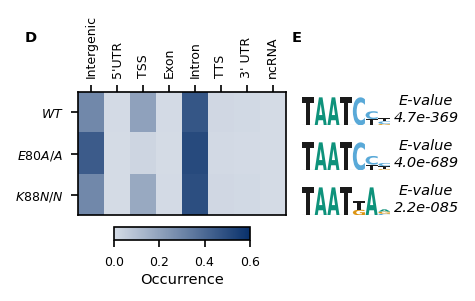

In [23]:
# Panel 3d. 3e. Genome annotation enrichement and de novo motif
# set up the figure
fig = plt.figure(figsize=(3,1.1), dpi=150)
gs = fig.add_gridspec(nrows=4, ncols=3, width_ratios=[3,1.5,1], height_ratios=[1,1,1,.4])
gs.update(left=0.1,right=0.95,top=0.95,bottom=0.05,wspace=0.01,hspace=0.4) #padding for each grid space

# Panel d. Enrichement heatmap
ax = fig.add_subplot(gs[:-1,0])
vmax = 0.6
annot_df = full_annot_df.T
# reorder the annotation
annot_df = annot_df.loc[:,annot_order.index].rename(columns=annot_order)
heatmap = ax.imshow(annot_df, aspect="auto", vmin=0, vmax=vmax, cmap=single_heat_colors)
ax.set_yticks(np.arange(len(annot_df.index)))
ax.set_yticklabels([f"$\it{n.upper()}$" for n in ["wt",'e80a/a',"k88n/n"]])
ax.set_xticks(np.arange(len(annot_df.columns)))
ax.xaxis.set_ticks_position("top")
ax.set_xticklabels(annot_df.columns, rotation=90)
# add numbers to each cell
#specseq_plot_utils.annotate_heatmap(ax, annot_df, thresh)

# Add a colorbar
cbar_ax = fig.add_subplot(gs[3,0].subgridspec(1,6)[1:-1])
colorbar = fig.colorbar(heatmap, cax=cbar_ax, label="Occurrence", orientation="horizontal", ticks=[0,.2,.4,.6])
cbar_ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

# Panel e. de novo motif search HD PWMs and DREME enrichement stats
pwm_axes = []
for i,name in enumerate(["wt_olap.DREME.1", "e80a_olap.DREME.1", "k88n_olap.DREME.1"]):
    pwm_ax = fig.add_subplot(gs[i,1].subgridspec(1,7)[1:])
    #pwm_ax.axis("off")
    pwm_ax.set_frame_on(False)
    pwm = hdmuts_meme_pwms[name].copy()
    if "k88n" in name: # plot reverse complement for k88n
        pwm = specseq_ewm_utils.get_motif_revcomp(pwm)
    fig, pwm_ax, pwm_logo = specseq_plot_utils.make_pwm_logo(pwm, sequence_design=None, add_filler=False, figax=(fig, pwm_ax))
    pwm_ax.set_ylim(bottom=0, top=2.4)
    pwm_ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    pwm_ax.xaxis.set_visible(False)
    pwm_ax.yaxis.set_visible(False)
    [s.set_visible(False) for s in pwm_ax.spines.values()]
    # store the pwm axes for adding panel letter
    pwm_axes.append(pwm_ax)
    # add DREME stats
    stats_text = hdmuts_meme_stats[name]
    stats_ax = fig.add_subplot(gs[i,2])
    stats_ax.axis("off")
    stats_ax.text(.5,.5, f"E-value\n{stats_text}", fontsize=mpl.rcParams["axes.titlesize"], style="italic", va="center", ha="center")

# add panel labels
specseq_plot_utils.add_letter(ax, -.2, 1.5, "D")
specseq_plot_utils.add_letter(pwm_axes[0], 0, 2.85, "E")

In [24]:
specseq_plot_utils.save_fig(fig, os.path.join(outbase_dir, "manuscript", "figure3d_annotation_motif"), timestamp=False, tight_layout=False)

### III. Expression: reporter assay & RNA-seq in developing retina

### a. pRho & pSOP luciferase reporter assay

In [13]:
# prepare the data
Rholuc_df = pd.read_csv(os.path.join(rna_basedir, "luciferase_summary.csv"), sep=",")
Rholuc_df = pd.melt(Rholuc_df, id_vars=["protein", "ng"], value_vars=["rep1", "rep2", "rep3"], var_name="rep", value_name="fc")

F_onewayResult(statistic=237.5086719392141, pvalue=3.7232678420812205e-08)


/Users/yiqiao/opt/anaconda3/envs/specseq/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1214: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
/Users/yiqiao/opt/anaconda3/envs/specseq/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1215: RuntimeWarning: invalid value encountered in double_scalars
  hival = q3 + whis * stats['iqr']


,index,variable,value
4,WT,E80A,0.001000
8,WT,K88N,0.001000
9,E80A,K88N,0.001000
12,WT,R90W,0.001000
13,E80A,R90W,0.001000
14,K88N,R90W,0.825098


/Users/yiqiao/opt/anaconda3/envs/specseq/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/yiqiao/opt/anaconda3/envs/specseq/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

WT vs. E80A: Custom statistical test, P_val:1.000e-03
WT vs. K88N: Custom statistical test, P_val:1.000e-03
WT vs. R90W: Custom statistical test, P_val:1.000e-03


(<AxesSubplot:title={'center':'pRho-luc'}, xlabel='CRX Protein', ylabel='Relative luciferase\nactivity (FC/WT)'>,
  <statannotations.Annotation.Annotation at 0x163e69190>])

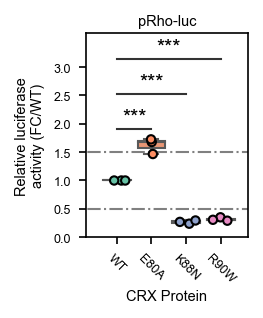

In [19]:
# Panel 4a. pRho luciferase reporter assay scatter plot
data_to_plot = Rholuc_df.loc[lambda df: df.ng == 100, :].reset_index(drop=True)
# re-order so that WT is at top of the figure - only for horizontal plot
#data_to_plot = data_to_plot.iloc[::-1].reset_index(drop=True)

fig, ax = plt.subplots(figsize=(1.4,1.8), dpi=150)

ax = sns.stripplot(y="fc", x="protein", data=data_to_plot, palette="Set2", edgecolor="black", dodge=False, linewidth=1, marker="o", size=4, jitter=.3, orient='v', ax=ax)
ax = sns.boxplot(y="fc", x="protein", data=data_to_plot, whis=np.inf, palette="Set2", orient='v', ax=ax)

# decorations
ax.set_ylim(0,2.8)
ax.set_yticks([0,.5,1.0,1.5,2.0,2.5,3.0])
ax.set_xlim(-.9,3.8)
ax.set(xlabel="CRX Protein", title="pRho-luc")
ax.set_ylabel("Relative luciferase\nactivity (FC/WT)", labelpad=4)
ax.set_xticklabels(ax.get_xticklabels(), rotation = -45)

ax.axhline(y=.5, xmin=-.9, xmax=3.8, linewidth=1, linestyle="-.", color="grey")
ax.axhline(y=1.5, xmin=-.9, xmax=3.8, linewidth=1, linestyle="-.", color="grey")

# compute statistics and add annotation to plot
# do two-way ANOVA with Tukey HSD and store p-values for manual annotation
# transform data to array-like data
gb = data_to_plot.groupby("protein")
data_to_anova = [data_to_plot.groupby("protein").get_group(x).fc.to_list() for x in data_to_plot.groupby("protein").groups]
# print one-way ANOVA F statistics
print(stats.f_oneway(*data_to_anova))
# Turkey test
tukey_df = posthoc_tukey(data_to_plot, val_col="fc", group_col="protein")
# tidy up Turkey test results
remove = np.tril(np.ones(tukey_df.shape), k=0).astype("bool")
tukey_df[remove] = np.nan
molten_df = tukey_df.melt(ignore_index=False).reset_index().dropna()
molten_df
# print Turkey test result table
display(molten_df)
# retrieve p-values between mutant-wt comparison for plotting
pairs = [(i[1]["index"], i[1]["variable"]) for i in molten_df.iterrows() if i[1]["index"]=="WT"]
p_values = [i[1]["value"] for i in molten_df.iterrows() if i[1]["index"]=="WT"]

# only plot p-values compared to WT
annotator = Annotator(
    ax, pairs, y="fc", x="protein", data=data_to_plot, orient='v', order=["WT","E80A","K88N","R90W"], verbose=1
)
annotator.configure(text_format='star', loc='inside', line_width=mpl.rcParams["lines.linewidth"], line_height=0.0)
annotator.set_pvalues_and_annotate(p_values)


In [35]:
specseq_plot_utils.save_fig(fig, prefix=os.path.join(outbase_dir, "manuscript", "figure7e_pRho_luciferase"), timestamp=False, tight_layout=False)

In [16]:
# prepare the data
SOPluc_df = pd.read_csv(os.path.join(luc_dir, "pSOP_summary.csv"), sep=",")
SOPluc_df = pd.melt(SOPluc_df, id_vars=["protein", "ng"], value_vars=["norm.rep1", "norm.rep2", "norm.rep3"], var_name="rep", value_name="fc")

F_onewayResult(statistic=510.0084385467631, pvalue=1.797633210616121e-09)


/Users/yiqiao/opt/anaconda3/envs/specseq/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1214: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
/Users/yiqiao/opt/anaconda3/envs/specseq/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1215: RuntimeWarning: invalid value encountered in double_scalars
  hival = q3 + whis * stats['iqr']


,index,variable,value
4,WT,E80A,0.0010
8,WT,K88N,0.0010
9,E80A,K88N,0.0010
12,WT,R90W,0.0010
13,E80A,R90W,0.0010
14,K88N,R90W,0.8555


/Users/yiqiao/opt/anaconda3/envs/specseq/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/yiqiao/opt/anaconda3/envs/specseq/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/yiqiao/opt/anaconda3/envs/specseq/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

WT vs. E80A: Custom statistical test, P_val:1.000e-03
WT vs. K88N: Custom statistical test, P_val:1.000e-03
WT vs. R90W: Custom statistical test, P_val:1.000e-03


(<AxesSubplot:title={'center':'pOpn1sw-luc'}, xlabel='CRX Protein', ylabel='Relative luciferase\nactivity (FC/WT)'>,
  <statannotations.Annotation.Annotation at 0x164002700>])

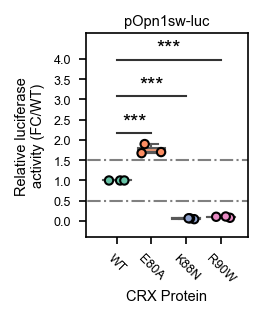

In [20]:
# Panel 4a. pRho luciferase reporter assay scatter plot
data_to_plot = SOPluc_df.loc[lambda df: (df.ng == 200) & (df.protein!="K88Q"), :].reset_index(drop=True)
# re-order so that WT is at top of the figure - only for horizontal plot
#data_to_plot = data_to_plot.iloc[::-1].reset_index(drop=True)

fig, ax = plt.subplots(figsize=(1.4,1.8), dpi=150)

ax = sns.stripplot(y="fc", x="protein", data=data_to_plot, palette="Set2", edgecolor="black", dodge=False, linewidth=1, marker="o", size=4, jitter=.3, orient='v', ax=ax)
ax = sns.boxplot(y="fc", x="protein", data=data_to_plot, whis=np.inf, palette="Set2", orient='v', ax=ax)

# decorations
ax.set_ylim(-.4,4.0)
ax.set_yticks([0,.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0])
ax.set_xlim(-.9,3.8)
ax.set(xlabel="CRX Protein", title="pOpn1sw-luc")
ax.set_ylabel("Relative luciferase\nactivity (FC/WT)", labelpad=4)
ax.set_xticklabels(ax.get_xticklabels(), rotation = -45)

ax.axhline(y=.5, xmin=-.9, xmax=3.8, linewidth=1, linestyle="-.", color="grey")
ax.axhline(y=1.5, xmin=-.9, xmax=3.8, linewidth=1, linestyle="-.", color="grey")

# compute statistics and add annotation to plot
# do two-way ANOVA with Tukey HSD and store p-values for manual annotation
# transform data to array-like data
gb = data_to_plot.groupby("protein")
data_to_anova = [data_to_plot.groupby("protein").get_group(x).fc.to_list() for x in data_to_plot.groupby("protein").groups]
# print one-way ANOVA F statistics
print(stats.f_oneway(*data_to_anova))
# Turkey test
tukey_df = posthoc_tukey(data_to_plot, val_col="fc", group_col="protein")
# tidy up Turkey test results
remove = np.tril(np.ones(tukey_df.shape), k=0).astype("bool")
tukey_df[remove] = np.nan
molten_df = tukey_df.melt(ignore_index=False).reset_index().dropna()
molten_df
# print Turkey test result table
display(molten_df)
# retrieve p-values between mutant-wt comparison for plotting
pairs = [(i[1]["index"], i[1]["variable"]) for i in molten_df.iterrows() if i[1]["index"]=="WT"]
p_values = [i[1]["value"] for i in molten_df.iterrows() if i[1]["index"]=="WT"]

# only plot p-values compared to WT
annotator = Annotator(
    ax, pairs, y="fc", x="protein", data=data_to_plot, orient='v', order=["WT","E80A","K88N","R90W"]
)
annotator.configure(text_format='star', loc='inside', line_width=mpl.rcParams["lines.linewidth"], line_height=0.0)
annotator.set_pvalues_and_annotate(p_values)


In [10]:
specseq_plot_utils.save_fig(fig, prefix=os.path.join(outbase_dir, "extended", "extended.figure7b_SOP_luciferase"), timestamp=False, tight_layout=False)

### b. definition of CRX-dependent and independent genes

In [19]:
# Find cluster 1 peaks lost in r90w/w
r90w_lost_peaks  = chip_full_matrix.loc[lambda df: df["peak.id"].isin(chip_full_matrix.loc[lambda df: df["cluster"]=="Cluster1","peak.id"])]
# annotate by binding changes in r90w/w
r90w_lost_peaks = chip_rna_annotator.annot_chip_lfc(r90w_lost_peaks, "chip.r90w.lfc", "chip.r90w.fdr", chip_lfc_th=1.0, chip_fdr_th=0.05)
# keep only r90w related fields
r90w_lost_peaks = r90w_lost_peaks.loc[:, ["seqnames","start","end","width","chip.r90w.lfc", "chip.r90w.fdr","chip_group"]]
display(r90w_lost_peaks.groupby("chip_group")["chip.r90w.lfc"].count())

chip_group
Lost         7695
No Change    1277
No Peak         0
Name: chip.r90w.lfc, dtype: int64

In [20]:
# Using adult retina expression data, find gained/lost genes when CRX is lost
r90w_rna = chip_rna_annotator.rna_fpm_filter(rna_compiled_counts, rna_compiled_lfc, genotypes=["wt", "r_hom"], age="p21", fpm_th=2)
r90w_rna = chip_rna_annotator.annot_rna_lfc(r90w_rna, "p21.rhom.lfc", "p21.rhom.padj", rna_lfc_th=.6, rna_padj_th=1e-5, simplify=False) #.dropna(axis="index",how="any") # drop genes where padj is NA
r90w_rna = r90w_rna.loc[:, ["gene","p21.rhom.lfc", "p21.rhom.padj", "rna_group"]]
crx_dependent_gene = pd.merge(r90w_lost_peaks, great_map, how="inner", on=["seqnames", "start", "end", "width"]).merge(r90w_rna, how="inner").reset_index(drop=True)

del(r90w_lost_peaks)
del(r90w_rna)

# sort by abs distTSS and keep only the cloest gene (within 100kb to TSS)
# Note: when cutoff at 5kb to TSS, basdically the same as no 5kb filter
crx_dependent_gene = chip_rna_annotator.is_nearby_peak(crx_dependent_gene, DE_cutoff=100)
crx_dependent_gene = crx_dependent_gene.sort_values(by="distTSS", key=abs).drop_duplicates('peak.id', keep='first', inplace=False).sort_values(by="seqnames")
crx_dependent_gene = crx_dependent_gene[lambda df:df.chip_group=="Lost"].reset_index(drop=True)
crx_dependent_gene.groupby("chip_group")["rna_group"].value_counts().unstack().fillna(0)

rna_group,Gained,Lost,No Change
chip_group,,,
Lost,135,617,5565


In [84]:
# save the dataframe
crx_dependent_gene.to_csv(os.path.join(rna_basedir, "crx_dependent_genes.tsv"), sep="\t", index=False, header=True)

In [9]:
crx_dependent_gene = pd.read_csv(os.path.join(rna_basedir, "crx_dependent_genes.tsv"), sep="\t", header=0)

#### functional evidence of CRX-dependent activated and -independent genes

In [21]:
def get_topN_GOterms(GOtable,top_n=5):
    # check if the GOtable contains top_n entries
    # if not, return all entries
    if len(GOtable.index) > int(top_n):
        top_df = GOtable.sort_values("p.adjust").head(top_n)
    else:
        top_df = GOtable.sort_values("p.adjust")

    return top_df

/tmp/ipykernel_1239/3783068678.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str.upper(age) for age in select_ages])


Text(-0.14, 1.2, 'F')

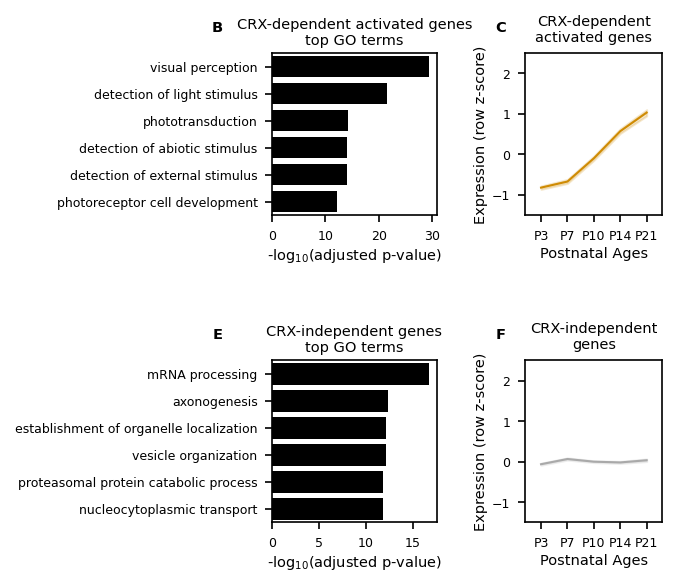

In [31]:
# Extended Data Fig.4 deifnition of CRX-dependency and functional confirmation
# set up the figure
gs_kw = dict(width_ratios=[1.2,1], height_ratios=[1,1], wspace=0.1, hspace=0.2)
fig, ax_list = plt.subplots(ncols=2, nrows=2, figsize=(4.4,3.8), dpi=150,
                            constrained_layout=True,
                            gridspec_kw=gs_kw)

# Panel c.f. Expression pattern during normal development
select_ages = ["p3","p7","p10","p14","p21"]
# retireve gene lists and their group assignment 
data = crx_dependent_gene[["gene","rna_group"]].copy()
# retrieve row z-score from Aldiri 2017 expression dataset
data = data.merge(clean_aldiri_rowz, on="gene", how="inner").reset_index(drop=True) # use postnatal ages only

fig, ax_list[:,1] = rnaseq_plot_utils.dev_line_by_rnaGp(data=data, morder=["Lost","No Change"], mpal={"Lost":"#CF8B03", "No Change":"#A9A9A9"}, xlabel="Postnatal Ages", ylabel="Expression (row z-score)", uniform_y=True, figax=(fig, ax_list[:,1]))

# minor adjustments
for ax, label in zip(ax_list[:,1],["CRX-dependent\nactivated genes","CRX-independent\ngenes"]):
    [tick.set_rotation(0) for tick in ax.get_xticklabels()]
    ax.set_xlim(-.6,len(select_ages)-.4)
    ax.set_ylim(-1.5,2.5)
    ax.set_xticklabels([str.upper(age) for age in select_ages])
    ax.set_title(label, pad=4, va="bottom")
    ax.yaxis.set_label_position("left")
    ax.yaxis.set_visible(True)

# Panel b.e. GO enrichement barcharts
# dep Act
depAct_df = pd.read_csv(os.path.join(rna_basedir, "gene.ontology", "crx_depAct_genes.tsv"), sep="\t", header=0)
depAct_df = get_topN_GOterms(depAct_df,top_n=6)
#display(depAct_df)

# convert padj to -log10 scale
depAct_df["-log10padj"] = -np.log10(depAct_df["p.adjust"])

ax = ax_list[0,0]
ax = sns.barplot(data=depAct_df, x="-log10padj", y="Description", color="k", dodge=False, ax=ax)

ax.set_title(f"CRX-dependent activated genes\ntop GO terms")
ax.set_xlabel("-$log_{10}$(adjusted p-value)")
ax.set_ylabel("")
ax.legend([],[],frameon=False)

# indep
indep_df = pd.read_csv(os.path.join(rna_basedir, "gene.ontology", "crx_independent_genes.tsv"), sep="\t", header=0)
indep_df = indep_df.iloc[[0,2,3,4,7,8],:]
#display(indep_df)

# convert padj to -log10 scale
indep_df["-log10padj"] = -np.log10(indep_df["p.adjust"])

ax = ax_list[1,0]
ax = sns.barplot(data=indep_df, x="-log10padj", y="Description", color="k", dodge=False, ax=ax)

ax.set_title(f"CRX-independent genes\ntop GO terms")
ax.set_xlabel("-$log_{10}$(adjusted p-value)")
ax.set_ylabel("")
ax.legend([],[],frameon=False)

# add panel labels
specseq_plot_utils.add_letter(ax_list[0,0], -.3, 1.2, "B")
specseq_plot_utils.add_letter(ax_list[1,0], -.3, 1.2, "E")
specseq_plot_utils.add_letter(ax_list[0,1], -.14, 1.2, "C")
specseq_plot_utils.add_letter(ax_list[1,1], -.14, 1.2, "F")


In [32]:
specseq_plot_utils.save_fig(fig, os.path.join(outbase_dir,"extended","extended.figure4_crxdepGene_definition"), tight_layout=False, timestamp=False)

### c. sample wise correlation using CRX-dependant activated gene expression at P10

In [22]:
# filter genes with at least 2 cpm on average in p10 RNAseq dataset of this study
p10_rna_lfc = chip_rna_annotator.rna_fpm_filter(rna_compiled_counts, rna_compiled_lfc, age="p10", fpm_th=2).loc[:, lambda df: ["GENEID","gene"]+list(df.columns[df.columns.str.contains("p10")])]
p10_rna_count = rna_compiled_counts.loc[lambda df: df["gene"].isin(p10_rna_lfc["gene"]), lambda df: ["gene"]+list(df.columns[df.columns.str.contains("p10")])]
p10_rna_count = p10_rna_count.drop_duplicates("gene", keep="first").set_index("gene")

# filter genes with at least 2 cpm on average in postnatal RNAseq dataset of Aldiri 2017 study
mask = aldiri_norm_counts.loc[:, aldiri_norm_counts.columns[5:]] >= 2
aldiri_rna_count = aldiri_norm_counts[mask.sum(axis=1) == len(mask.columns)].reset_index(drop=True)

# compile the p10 rna and aldiri rna data
p10_aldiri_rna = pd.merge(p10_rna_count, aldiri_rna_count, how="inner", on="gene").drop(columns = "GENEID").set_index("gene")
age_order = pd.Series(["p3","p7","p10","p14","p21"])

In [23]:
# compile the p10 crx hd mutant rna, aldiri rna, and CRX-dependent activated gene data
p10_aldiri_depAct_rna = p10_aldiri_rna.loc[lambda df: df.index.isin(crx_dependent_gene.loc[lambda df: df["rna_group"]=="Lost", "gene"]),:]
# calculate pearson correlation coefficient
p10_aldiri_depAct_rna_corr_df = p10_aldiri_depAct_rna.corr(method="pearson").loc[age_order, p10_aldiri_depAct_rna.columns[p10_aldiri_depAct_rna.columns.str.contains("p10")]]

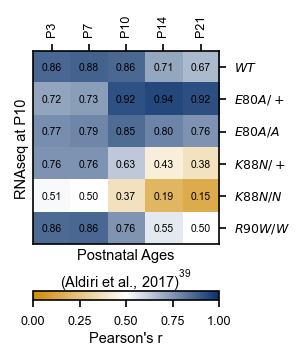

In [36]:
# Panel 4a. sample wise correlation heatmap
fig, ax = plt.subplots(figsize=(1.6,2.2), dpi=150)

vmax=1.0
vmin=0.0
thresh = 1
age="p10"

# reorder the PCC dataframe
order = age+"."+pd.Series(["wt_hom","e_het","e_hom","k_het","k_hom","r_hom"])
aldiri_rna_corr_df = p10_aldiri_depAct_rna_corr_df.loc[:,order]
heatmap = ax.imshow(aldiri_rna_corr_df.T, aspect="auto", vmin=vmin, vmax=vmax, cmap=div_heat_colors)
ax.xaxis.tick_top()
ax.set_xticks(np.arange(len(aldiri_rna_corr_df.index)))
ax.set_xticklabels([str.upper(age) for age in aldiri_rna_corr_df.index], rotation=90, ha="center")
ax.yaxis.tick_right()
ax.set_yticks(np.arange(len(aldiri_rna_corr_df.columns)))
ax.set_yticklabels([f"$\it{name}$" for name in ["WT", "E80A/+", "E80A/A", "K88N/+", "K88N/N", "R90W/W"]], va="center")
ax.set_xlabel(f"Postnatal Ages\n(Aldiri et al., 2017)"+r"$^{39}$")
ax.set_ylabel(f"RNAseq at {str.upper(age)}")

specseq_plot_utils.annotate_heatmap(ax, aldiri_rna_corr_df, thresh)

# Add a colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad="24%")
colorbar = fig.colorbar(heatmap, cax=cax, orientation="horizontal", label="Pearson's r")

# add panel label
#specseq_plot_utils.add_letter(ax, -.15, 1.2, "a")

In [37]:
specseq_plot_utils.save_fig(fig, os.path.join(outbase_dir,"manuscript","figure4a_p10_aldiri_crxdepActGenes.pearsonr"), tight_layout=False, timestamp=False)

### d. definition of differentially expressed genes (DEG) in each hd mutant model

In [27]:
# first annotate differentially expressed genes in each genotype
DEG_summary=pd.DataFrame(index=["No Change", "Gained", "Lost"])
DEgene_ser = {}
for rna in ["ehet", "ehom", "khet", "khom", "rhom"]:
    # for each genotype, annotate the DEGs
    lfc_col = f"p10.{rna}.lfc"
    padj_col = f"p10.{rna}.padj"
    annotated_DEG_df = rna_compiled_lfc.loc[:,["GENEID", "gene", lfc_col, padj_col]].copy()
    annotated_DEG_df = chip_rna_annotator.annot_rna_lfc(data=annotated_DEG_df, rna_lfc=lfc_col, rna_padj=padj_col, rna_lfc_th=1.0, rna_padj_th=1.0e-2, simplify=False).drop(columns="GENEID")
    annotated_DEG_df = annotated_DEG_df.dropna(axis="index", how="any")
    annotated_DEG_df = annotated_DEG_df.drop_duplicates('gene', keep='first', inplace=False).reset_index(drop=True)

    # count the number of DEGs and store to summary dataframe
    summary = pd.DataFrame(annotated_DEG_df.rna_group.value_counts().rename(f"p10.{rna}"))
    DEG_summary = pd.concat([DEG_summary, summary], axis=1)

    # save the dataframes
    DEgene_ser[f"p10.{rna}"] = annotated_DEG_df

DEgene_ser = pd.Series(DEgene_ser)
display(DEG_summary)

,p10.ehet,p10.ehom,p10.khet,p10.khom,p10.rhom
No Change,14192,14777,14741,14157,14338
Gained,371,333,151,655,243
Lost,201,249,169,547,480


In [28]:
# now for E80A and K88N models, identify DEGs in either hets or homs, or both
paired_DEgene_ser = {}
for het,hom in zip(["p10.ehet","p10.khet"],["p10.ehom","p10.khom"]): # only e80a and k88n mutants
    DE_df, noDE_df = chip_rna_annotator.annot_paired_rna(DEgene_ser[het], DEgene_ser[hom], diff_th=2.0, simplify=True)
    print(f"number of DEGs in {het} and {hom}: {str(len(DE_df.index))}")
    # store the annotated table
    paired_DEgene_ser[f"{het}_vs_{hom}"] = (DE_df, noDE_df) 

paired_DEgene_ser = pd.Series(paired_DEgene_ser)

number of DEGs in p10.ehet and p10.ehom: 879
number of DEGs in p10.khet and p10.khom: 1271


### e. differential expression heatmap of CRX-depednent activated genes in $Crx^{E80A}$ and $Crx^{K88N}$ mutants

In [29]:
# retrieve p10 expression lfc matrix of crx-dependent activated genes
pick_genotypes = ["ehet","ehom","khet","khom","rhom"]
crxdepAct_rna_lfc = p10_rna_lfc.loc[lambda df: df.gene.isin(crx_dependent_gene.loc[lambda df: df.rna_group == "Lost","gene"]),["gene"]+list("p10."+pd.Series(pick_genotypes)+".lfc")].copy()
# we care about genes that are differentially expressed in one of the HD mutant genotypes
e80a_DEGs = paired_DEgene_ser[0][0].gene
k88n_DEGs = paired_DEgene_ser[1][0].gene
crxdepAct_rna_lfc = crxdepAct_rna_lfc.loc[lambda df: df.gene.isin(e80a_DEGs) | df.gene.isin(k88n_DEGs)]
# drop any gene duplicates (GENEIDs are unique)
crxdepAct_rna_lfc = crxdepAct_rna_lfc.drop_duplicates('gene', keep='first', inplace=False).reset_index(drop=True).set_index('gene').dropna(axis="index",how="all")

# hierarchical clustering of the lfc expression matrix 
crxdepAct_rna_lfc_cg = chipseq_plot_utils.chip_intensity_heatmap(data=crxdepAct_rna_lfc.iloc[:,:].copy(),  hm_title=None, hm_xlabel=None, cb_title=None, cmap=div_heat_colors, paramdict=dict(z_score=1))
crxdepAct_rna_lfc_cg.ax_row_dendrogram.set_visible(True)
new_order = crxdepAct_rna_lfc_cg.dendrogram_row.reordered_ind
plt.close()

# reorder the lfc dataframe based on clustering
reordered_crxdepAct_rna_lfc = crxdepAct_rna_lfc.iloc[new_order,:].reset_index(drop=True)
# reverse the order so that up-regulated genes are on top
reordered_crxdepAct_rna_lfc = reordered_crxdepAct_rna_lfc.loc[::-1].reset_index(drop=True)

186


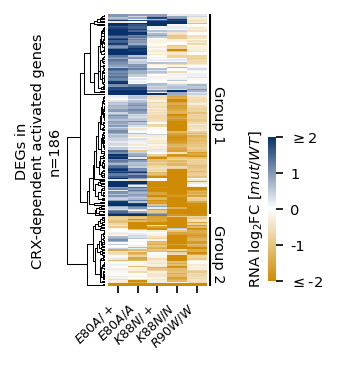

In [29]:
# Panel 4b. expression heatmap with dendrogram
# set up the figure
fig, ax_list = plt.subplots(ncols=4, figsize=(1.6,2.4), dpi=150, constrained_layout=False, gridspec_kw=dict(width_ratios=[.4,1,.2,.2], wspace=.05))
heatmap_ax = ax_list[1]

# make the log2FC heatmap
heatmap_ax = sns.heatmap(data=reordered_crxdepAct_rna_lfc, ax=heatmap_ax, cmap=div_heat_colors, vmin=-2, vmax=2, cbar=False)
heatmap_ax.set_yticks([])
        
heatmap_ax.set_xticklabels([f"$\it{pretty_names[name]}$" for name in pick_genotypes], rotation=45, ha="right", va="top")
heatmap_ax.yaxis.set_visible(False)

# plot the dendrogram on the left
dendro_ax = ax_list[0]

hierarchy.set_link_color_palette(["k"])
# Override the default linewidth.
mpl.rcParams['lines.linewidth'] = 0.5
decdro_dict = scipy.cluster.hierarchy.dendrogram(Z=crxdepAct_rna_lfc_cg.dendrogram_row.linkage, ax = dendro_ax, distance_sort="ascending", orientation="left", above_threshold_color='k')
dendro_ax.yaxis.set_visible(True)
dendro_ax.yaxis.set_ticks([])
dendro_ax.xaxis.set_visible(False)
dendro_ax.set_frame_on(False)

gene_num = len(reordered_crxdepAct_rna_lfc.index)
dendro_ax.set_ylabel(f"DEGs in\nCRX-dependent activated genes\nn={str(gene_num)}")
print(str(gene_num))

# reset to default after use
hierarchy.set_link_color_palette(None)
mpl.rcParams['lines.linewidth'] = 1.0

# add gene group labels to the right
ax_list[2].axis("off")
label_ax = ax_list[2]
# draw verticle lines
label_ax.axvline(x=.03, ymin=0, ymax=.25, color='k')
label_ax.axvline(x=.03, ymin=.27, ymax=1, color='k')
# draw group names
label_ax.text(.1, .12, "Group 2", fontsize=mpl.rcParams['axes.titlesize'], color='k', rotation=-90, verticalalignment="center")
label_ax.text(.1, .63, "Group 1", fontsize=mpl.rcParams['axes.titlesize'], color='k', rotation=-90, verticalalignment="center")

# add color bar separately
ax_list[3].axis("off")
cbar_ax = plt.axes([.97, .14, 0.03, 0.4])
cbar_ax.set_frame_on(False)
norm = mpl.colors.Normalize(vmin=-2, vmax=2)
colorbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=div_heat_colors), ticks=[-2,-1,0,1,2],
        cax=cbar_ax, orientation='vertical')
ticks = cbar_ax.get_yticks()
ticks = [f"{i:.0f}" for i in ticks]
ticks[-1] = r"$\geq$" + ticks[-1]
ticks[0] = r"$\leq$" + ticks[0]
cbar_ax.set_yticklabels(ticks)
cbar_ax.text(-.4,0, f"RNA $log_{2}$FC [$\itmut/WT$]", rotation=90, fontsize=mpl.rcParams['axes.titlesize'], va="center", ha="right")
cbar_ax.tick_params(labelsize=7, rotation=0)

# add panel label
#specseq_plot_utils.add_letter(dendro_ax, -.4, 1.1, "b")

In [31]:
specseq_plot_utils.save_fig(fig, os.path.join(outbase_dir,"manuscript","figure4b_p10_log2fc_heatmap"), tight_layout=False, timestamp=False)

### f. differential expression heatmap of selected genes from group1 and 2

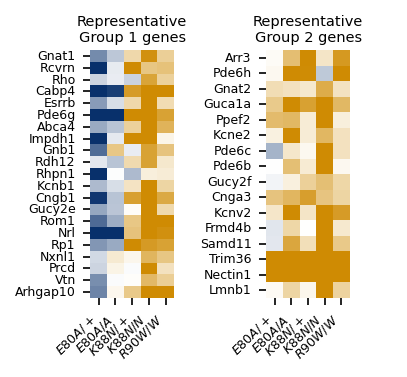

In [32]:
# Panel 4c.d. expression heatmap of selected group1 and group2 genes

# group 1 - gained in E but lost in K - rod enriched
group1_genelist = ["Gnat1","Rcvrn","Rho","Cabp4","Esrrb","Pde6g","Abca4","Impdh1","Gnb1","Rdh12","Rhpn1","Kcnb1","Cngb1","Gucy2e","Rom1","Nrl","Rp1","Nxnl1","Prcd","Vtn","Arhgap10"]
# group 2 - lost in all mutants - cone enriched
group2_genelist = ["Arr3","Pde6h","Gnat2","Guca1a","Ppef2","Kcne2","Pde6c","Pde6b","Gucy2f","Cnga3","Kcnv2","Frmd4b","Samd11","Trim36","Nectin1","Lmnb1"]

# set up the figure
fig, ax_list = plt.subplots(ncols=3, figsize=(2.6,2.4), dpi=150, constrained_layout=True, gridspec_kw=dict(width_ratios=[1,1,.2], wspace=0.2))

# Group1
ax = ax_list[0]
data = crxdepAct_rna_lfc.loc[lambda df: df.index.isin(group1_genelist),:].copy()
ax = sns.heatmap(data=data, ax=ax, cmap=div_heat_colors, vmin=-2, vmax=2, cbar=False, yticklabels=group1_genelist)

ax.set_xticklabels([f"$\it{pretty_names[name]}$" for name in pick_genotypes], rotation=45, ha="right", va="top")
ax.set_title(f"Representative\nGroup 1 genes")
ax.set_ylabel("")

# Group2
ax = ax_list[1]
data = crxdepAct_rna_lfc.loc[lambda df: df.index.isin(group2_genelist),:].copy()
ax = sns.heatmap(data=data, ax=ax, cmap=div_heat_colors, vmin=-2, vmax=2, cbar=False, yticklabels=group2_genelist)

ax.set_xticklabels([f"$\it{pretty_names[name]}$" for name in pick_genotypes], rotation=45, ha="right", va="top")
ax.set_title(f"Representative\nGroup 2 genes")
ax.set_ylabel("")

# add color bar separately
ax_list[2].axis("off")
for x_pos in [0.95]:
    cbar_ax = plt.axes([x_pos, .2, 0.02, 0.4])
    cbar_ax.set_frame_on(False)
    norm = mpl.colors.Normalize(vmin=-2, vmax=2)
    colorbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=div_heat_colors), ticks=[-2,-1,0,1,2],
            cax=cbar_ax, orientation='vertical')
    ticks = cbar_ax.get_yticks()
    ticks = [f"{i:.0f}" for i in ticks]
    ticks[-1] = r"$\geq$" + ticks[-1]
    ticks[0] = r"$\leq$" + ticks[0]
    cbar_ax.set_yticklabels(ticks)
    cbar_ax.tick_params(labelsize=7, rotation=0)

# remove colorbar
cbar_ax.remove()

# add panel labels
#specseq_plot_utils.add_letter(ax_list[0], -.5, 1.2, "c")
#specseq_plot_utils.add_letter(ax_list[1], -.5, 1.2, "d")

In [33]:
specseq_plot_utils.save_fig(fig, os.path.join(outbase_dir,"manuscript","figure4cd_p10_log2fc_byGroup"), tight_layout=False, timestamp=False)

### g. compare associated peak binding intensity for group1 and 2 genes

In [30]:
# first assign genes to group based on linkage
# cut the linkage matrix at the second level to assign genes to group1 or 2
Z = crxdepAct_rna_lfc_cg.dendrogram_row.linkage
cutree = cluster.hierarchy.cut_tree(Z, n_clusters=2)

crxdepAct_rna_annot_df = pd.DataFrame(cutree, columns={"rna_group"})
crxdepAct_rna_annot_df[["rna_group"]] = crxdepAct_rna_annot_df[["rna_group"]].mask(crxdepAct_rna_annot_df[["rna_group"]] == 0, 'Group1', inplace=False)
crxdepAct_rna_annot_df[["rna_group"]] = crxdepAct_rna_annot_df[["rna_group"]].mask(crxdepAct_rna_annot_df[["rna_group"]] == 1, 'Group2', inplace=False)

# append to the lfc matrix and reorder the dataframe as in the expression heatmap
crxdepAct_rna_lfc = crxdepAct_rna_lfc.reset_index(drop=False)
reordered_crxdepAct_rna_lfc = pd.concat([crxdepAct_rna_lfc, crxdepAct_rna_annot_df], axis=1, ignore_index=False).iloc[new_order,:].reset_index(drop=True)
del(crxdepAct_rna_annot_df)

# check the number of genes assigned to group1 or 2
display(reordered_crxdepAct_rna_lfc.rna_group.value_counts())

# Note: the full list of genes and their group definition can be found in Supplementary Table 3

Group1    138
Group2     48
Name: rna_group, dtype: int64

In [17]:
# identify peaks associated with genes in group1 and 2
crxdepAct_chip_int = reordered_crxdepAct_rna_lfc.merge(great_map.loc[:,["gene","distTSS","peak.id"]].copy(), how="left", on="gene").reset_index(drop=True)
crxdepAct_chip_int = chip_rna_annotator.is_nearby_peak(crxdepAct_chip_int, DE_cutoff=100)
crxdepAct_chip_int = crxdepAct_chip_int.merge(chip_full_matrix[["peak.id","WT","E80A", "K88N", "R90W"]], on="peak.id", how="left").reset_index(drop=True)

# convert binding intensity to log scale, add 1 to avoid error
crxdepAct_chip_int["log.wt"] = np.log2(crxdepAct_chip_int["WT"]+1)
crxdepAct_chip_int["log.e80a"] = np.log2(crxdepAct_chip_int["E80A"]+1)
crxdepAct_chip_int["log.k88n"] = np.log2(crxdepAct_chip_int["K88N"]+1)
crxdepAct_chip_int["log.r90w"] = np.log2(crxdepAct_chip_int["R90W"]+1)

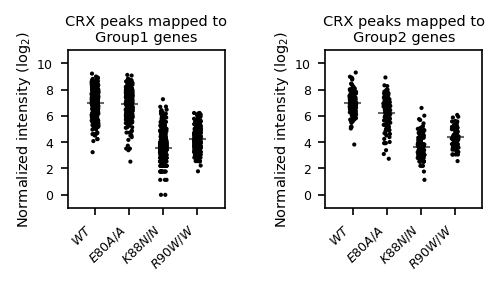

In [89]:
# Panel 4g.f strip plots comparing CRX binding intensity at peaks associated with group1 or 2 genes
# set up the figure
fig, ax_list = plt.subplots(ncols=2, figsize=(3.2,1.8), dpi=150, constrained_layout=True, gridspec_kw=dict(width_ratios=[1,1], wspace=0.2))


show_columns = ["log.wt","log.e80a","log.k88n","log.r90w"]
for gp, ax in zip(["Group1","Group2"], ax_list):
    # reshape data
    data_to_plot = crxdepAct_chip_int[lambda df: df.rna_group == gp].loc[:,["gene"]+show_columns].reset_index(drop=True)
    # convert wide to long dataframe
    data_to_plot = pd.melt(data_to_plot, id_vars=["gene"], value_vars=show_columns, var_name="protein", value_name="norm.counts")
    fig, ax =  rnaseq_plot_utils.strip_by_category(data=data_to_plot, x_column="protein", y_column="norm.counts", morder=show_columns,  mpal={od:"k" for od in show_columns}, markersize=2, add_mean=True, annot_bool=False, figax=(fig,ax))
    ax.set(title=f"CRX peaks mapped to\n{gp} genes", xlabel="", ylabel=r"Normalized intensity ($log_{2}$)") #Binding Intensity\n$log_{2}$(cpm+1)
    ax.set_xticklabels([f"$\it{genotype}$" for genotype in ["WT","E80A/A", "K88N/N", "R90W/W"]], rotation=45, horizontalalignment="right", verticalalignment="top")

    # make some space so that the plot looks nicer
    ax.set_xlim(-0.8,len(show_columns)-0.2)
    ax.set_ylim(-1,11)

# add panel labels
#specseq_plot_utils.add_letter(ax_list[0], -.3, 1.24, "e")
#specseq_plot_utils.add_letter(ax_list[1], -.3, 1.24, "f")

In [ ]:
specseq_plot_utils.save_fig(fig, os.path.join(outbase_dir,"manuscript","figure4ef_chipIntensity_byGroup"), tight_layout=False, timestamp=False)

In [18]:
crxdepAct_chip_int.head()

,gene,p10.ehet.lfc,p10.ehom.lfc,p10.khet.lfc,p10.khom.lfc,p10.rhom.lfc,rna_group,distTSS,peak.id,WT,E80A,K88N,R90W,log.wt,log.e80a,log.k88n,log.r90w
0,Arr3,-2.073481,-4.842027,-2.655436,-4.583216,-2.998810,Group2,-29.0,peak.9783,110.702356,97.521829,12.010990,17.156569,6.803516,6.622372,3.701659,4.182420
1,Pde6h,-2.090919,-4.535081,-2.748662,-5.399367,-2.384097,Group2,-4809.0,peak.7857,82.557689,40.712997,12.010990,17.156569,6.384701,5.382425,3.701659,4.182420
2,Eno2,-0.346491,-1.446877,0.181525,-0.243037,-0.632142,Group2,1308.0,peak.7811,79.743222,7.574511,8.407693,7.352815,6.335269,3.100054,3.233841,3.062263
3,Ppef2,-0.244267,-2.272474,-0.317174,-1.249149,-0.515605,Group2,-118.0,peak.7045,186.692956,38.819369,13.212089,35.538607,7.552231,5.315398,3.829047,5.191350
4,Lmnb1,-0.580687,-0.514290,-0.392862,-1.424606,-0.491336,Group2,-55688.0,peak.4484,135.094400,231.022585,10.809891,26.960323,7.088464,7.858121,3.561924,4.805309


Mann-Whitney U test statistic=18963.5, p-value=0.9392189979167098
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Group1 vs. Group2: Custom statistical test, P_val:9.392e-01
Mann-Whitney U test statistic=24880.5, p-value=8.321342586734043e-07
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Group1 vs. Group2: Custom statistical test, P_val:8.321e-07
Mann-Whitney U test statistic=18055.5, p-value=0.5036844508204281
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Group1 vs. Group2: Custom statistical test, P_val:5.037e-01
Mann-Whitney U test statistic=16973.0, p-value=0.11959584030215252
p-value a

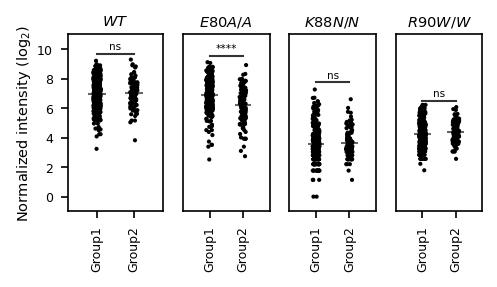

In [113]:
# Panel 4g.f strip plots comparing CRX binding intensity at peaks associated with group1 or 2 genes
# set up the figure
fig, ax_list = plt.subplots(ncols=4, figsize=(3.2,1.8), dpi=150, constrained_layout=True, gridspec_kw=dict(width_ratios=[1.1,1,1,1], wspace=0.05))


show_columns = ["Group1","Group2"]
for gp, tle, ax in zip(["log.wt","log.e80a","log.k88n","log.r90w"], ["WT","E80A/A", "K88N/N", "R90W/W"], ax_list):
    # reshape data
    data_to_plot = crxdepAct_chip_int.loc[:,["gene","rna_group",gp]].reset_index(drop=True)
    # convert wide to long dataframe
    #data_to_plot = pd.melt(data_to_plot, id_vars=["gene"], value_vars=gp, var_name="protein", value_name="norm.counts")
    fig, ax =  rnaseq_plot_utils.strip_by_category(data=data_to_plot, x_column="rna_group", y_column=gp, morder=show_columns,  mpal={od:"k" for od in show_columns}, markersize=2, add_mean=True, annot_bool=False, figax=(fig,ax))
    ax.set_xticklabels(["Group1","Group2"], rotation=90, horizontalalignment="center", verticalalignment="top")
    ax.set(title=f"$\it{tle}$", xlabel="") #Binding Intensity\n$log_{2}$(cpm+1)
    
    # obtain statistics and add annotation
    subgroup1_df = data_to_plot.loc[lambda df: df.rna_group=="Group1", gp]
    subgroup2_df = data_to_plot.loc[lambda df: df.rna_group=="Group2", gp]

    #w, pvalue = stats.shapiro(subgroup1_df)
    #print(f"Shapiro-Wilk test statistic={w}, p-value={pvalue}")

    #w, pvalue = stats.shapiro(subgroup2_df)
    #print(f"Shapiro-Wilk test statistic={w}, p-value={pvalue}")

    # perform two-sided test
    u, pvalue = stats.mannwhitneyu(x=subgroup1_df, y=subgroup2_df, alternative = 'two-sided')
    print(f"Mann-Whitney U test statistic={u}, p-value={pvalue}")
    
    annotator = Annotator(ax, pairs=[("Group1", "Group2")], data=data_to_plot, x="rna_group", y=gp, orient='v', order=["Group1","Group2"], verbose=1)
    annotator.configure(text_format='star', loc='inside', line_width=mpl.rcParams["lines.linewidth"], line_height=0.0)
    annotator.set_pvalues_and_annotate([pvalue])

    # make some space so that the plot looks nicer
    ax.set_xlim(-0.8,len(show_columns)-0.2)
    ax.set_ylim(-1,11)

# only show yaxis on the left-most plot
for i,ax in enumerate(ax_list):
    if i != 0:
        ax.get_yaxis().set_visible(False)
    else:
        ax.set(ylabel=r"Normalized intensity ($log_{2}$)")

# add panel labels
#specseq_plot_utils.add_letter(ax_list[0], -.3, 1.24, "e")
#specseq_plot_utils.add_letter(ax_list[1], -.3, 1.24, "f")

In [114]:
specseq_plot_utils.save_fig(fig, os.path.join(outbase_dir,"manuscript","figure4ef_chipIntensity_byGenotype"), tight_layout=False, timestamp=False)

#### h. compare baseline expression level of group1 and group2 genes

In [105]:
# annotate read count matrix with group1 and group2 genes
crxdepAct_rna_normCount = rna_compiled_counts.merge(reordered_crxdepAct_rna_lfc[["gene","rna_group"]], on="gene")
# convert to log10 tpm for visualization
crxdepAct_rna_normCount.iloc[:,2:-1] = crxdepAct_rna_normCount.iloc[:,2:-1].apply(lambda x: np.log10(x + 1))

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Group1 vs. Group2: t-test independent samples, P_val:2.995e-01 t=-1.040e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Group1 vs. Group2: t-test independent samples, P_val:8.154e-04 t=3.403e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Group1 vs. Group2: t-test independent samples, P_val:2.081e-05 t=4.367e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Group1 vs. Group2: t-test independent samples, P_v

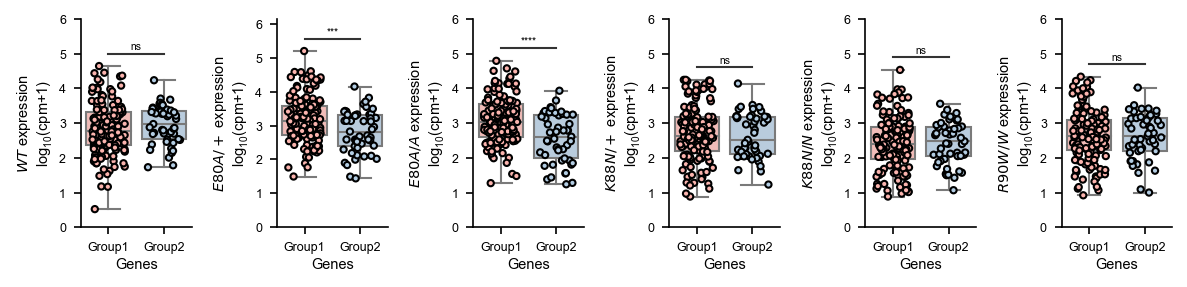

In [156]:
# strip plots comparing baseline/WT expression level of group1 or 2 genes
plot_genotypes=["wt_hom","e_het","e_hom","k_het","k_hom","r_hom"]
# set up the figure
fig, ax_list = plt.subplots(ncols=len(plot_genotypes), figsize=(1.3*len(plot_genotypes),1.8), dpi=150, constrained_layout=True, gridspec_kw=dict(width_ratios=[1]*len(plot_genotypes), wspace=0.1))

for idx,genotype in enumerate(plot_genotypes):
    ax = ax_list[idx]
    ax = sns.stripplot(x="rna_group", y=f"p10.{genotype}", data=crxdepAct_rna_normCount, palette="Pastel1", edgecolor="black", dodge=False, linewidth=1, marker="o", size=3, jitter=.3, ax=ax)
    ax = sns.boxplot(x="rna_group", y=f"p10.{genotype}", data=crxdepAct_rna_normCount, palette="Pastel1", linewidth=1, whis=np.inf, ax=ax)
    
    # decoration
    ax.set_xlabel("Genes")
    ax.set_ylim(0,6)
    name = genotype.replace("_","")
    ax.set_ylabel(f"$\it{pretty_names[name]}$ expression\n"+r"$log_{10}$(cpm+1)")

    # add annotation
    annotator = Annotator(ax, pairs=[("Group1", "Group2")], data=crxdepAct_rna_normCount, x="rna_group", y=f"p10.{genotype}", order=["Group1", "Group2"], verbose=1)
    annotator.configure(test='t-test_ind', text_format='star', loc='inside', line_width=mpl.rcParams["lines.linewidth"], line_height=0.0)
    annotator.apply_and_annotate()

    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)

    # add panel labels
    label = string.ascii_uppercase[idx]
    #specseq_plot_utils.add_letter(ax, -.3, 1.02, label)

In [157]:
specseq_plot_utils.save_fig(fig, os.path.join(outbase_dir,"extended", "extended.figure5.crxdependentGene_cpm"), tight_layout=False, timestamp=False)

### i. additional gene expression changes in CRX-independent category

In [31]:
paired_DEgene_ser.index

Index(['p10.ehet_vs_p10.ehom', 'p10.khet_vs_p10.khom'], dtype='object')

In [32]:
# identify additional DEGs in E80A and K88N mutants
independent_genelists = {}
# first retireve full list of CRX-independent genes
independent_genelists["full"] = crx_dependent_gene.loc[lambda df: df.rna_group == "No Change",:].drop_duplicates('gene', keep='first', inplace=False).reset_index(drop=True).set_index('gene').dropna(axis="index",how="all")

for genotype in paired_DEgene_ser.index:
    # mutant specific DEGs
    DE_df = paired_DEgene_ser[genotype][0].copy()
    # intersect CRX-independent gene set
    DE_df = DE_df.loc[lambda df: df.gene.isin(independent_genelists["full"].index),:]
    # drop duplicates
    DE_df = DE_df.drop_duplicates('gene', keep='first', inplace=False).reset_index(drop=True).set_index('gene').dropna(axis="index",how="all")
    
    independent_genelists[genotype] = DE_df

independent_genelists = pd.Series(independent_genelists)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


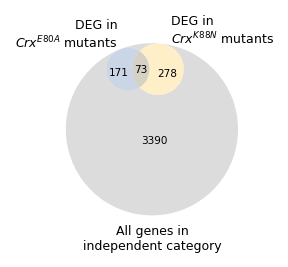

In [35]:
# Extended Data Fig.5 panel a. venn diagram
fig, venn_ax = plt.subplots(figsize=(1.8,1.8), dpi=150, constrained_layout=True)

v = venn3([set(independent_genelists[1].index.tolist()), set(independent_genelists[2].index.tolist()), set(independent_genelists[0].index.tolist())], 
            ax=venn_ax, 
            set_labels = ("DEG in\n"+"$\itCrx^{E80A}$ mutants", "DEG in\n"+"$\itCrx^{K88N}$ mutants", 'All genes in\nindependent category'), 
            set_colors=("#08306B", "#CF8B03", "#A9A9A9"))

#specseq_plot_utils.add_letter(venn_ax, -.1, 1.3, "A")

specseq_plot_utils.save_fig(fig, os.path.join(outbase_dir, "extended", "extended.figure5a.crxindependentGene_venn"), timestamp=False, tight_layout=False)

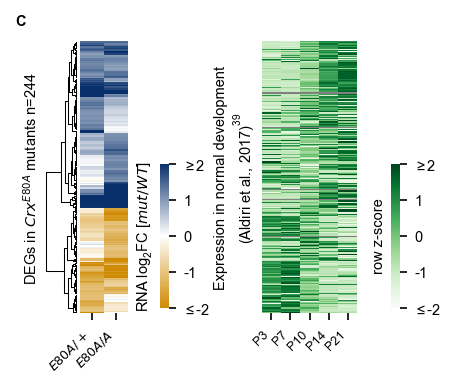

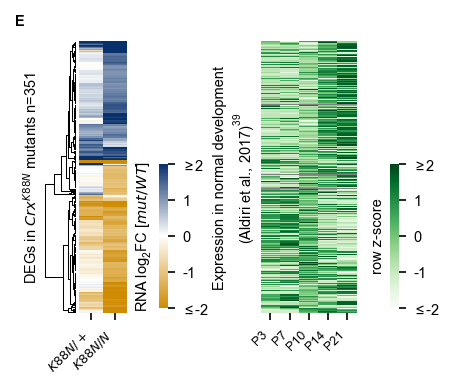

In [35]:
# Extended Data Fig.5 panel b.d. expression heatmap for p10 genes in the independent category
for i,(genotype,xticklabels,label) in enumerate(zip(["e80a","k88n"],[["ehet","ehom"],["khet","khom"]],["C","E"])):
        small_rna_lfc = independent_genelists[i+1].copy().reset_index(drop=False)

        # clustering
        small_rna_lfc_cg = chipseq_plot_utils.chip_intensity_heatmap(data=small_rna_lfc.loc[:,small_rna_lfc.columns.str.contains("lfc")],  hm_title=None, hm_xlabel=None, cb_title=None, cmap=div_heat_colors, paramdict=dict(z_score=None))
        new_order = small_rna_lfc_cg.dendrogram_row.reordered_ind
        plt.close()
        # reorder the differential expression dataframe based on clustering
        reordered_small_rna_lfc = small_rna_lfc.iloc[new_order,:].reset_index(drop=True)

        # attach the aldiri expression data
        reordered_small_rna_lfc = pd.merge(reordered_small_rna_lfc, clean_aldiri_rowz, how="left", on="gene").drop_duplicates('gene', keep='first', inplace=False).reset_index(drop=True).set_index('gene')#.dropna(axis="index",how="all")
        
        # adjust order so that over-expressed genes are on top
        if genotype == "e80a":
                reordered_small_rna_lfc = reordered_small_rna_lfc.loc[::-1].reset_index(drop=True)

        # make the independent group log2 FC and aldiri data side by side
        fig, ax_list = plt.subplots(ncols=5, figsize=(2.8,2.4), dpi=150, constrained_layout=False, gridspec_kw=dict(width_ratios=[.4,.6,1.6,1.2,.12], wspace=.05))

        ax = ax_list[1]
        ax = sns.heatmap(data=reordered_small_rna_lfc.loc[:,lambda df: df.columns.str.contains("lfc")], ax=ax, cmap=div_heat_colors, vmin=-2, vmax=2, cbar=False)
        ax.set_xticklabels([f"$\it{pretty_names[name]}$" for name in xticklabels], rotation=45, ha="right", va="top")
        ax.set_yticks([])
        ax.set_ylabel("")

        ax = ax_list[3]
        ax = sns.heatmap(data=reordered_small_rna_lfc.loc[:,["p3","p7","p10","p14","p21"]], ax=ax, cmap="Greens", vmin=-2, vmax=2, cbar=False)
        ax.set_facecolor('grey') # masked missing values to grey
        ax.set_xticks([.5,1.5,2.5,3.5,4.5])
        ax.set_xticklabels(["P3","P7","P10","P14","P21"], rotation=45, ha="right", va="top")
        ax.set_yticks([])
        ax.set_ylabel(f"Expression in normal development\n(Aldiri et al., 2017)"+r"$^{39}$")
        

        # add dendrogram to the left of the rna lfc heatmap
        dendro_ax = ax_list[0]
        
        hierarchy.set_link_color_palette(["k"])
        # Override the default linewidth.
        mpl.rcParams['lines.linewidth'] = 0.5
        decdro_dict = scipy.cluster.hierarchy.dendrogram(Z=small_rna_lfc_cg.dendrogram_row.linkage, ax = dendro_ax, distance_sort="ascending", orientation="left", above_threshold_color='k')
        dendro_ax.yaxis.set_visible(True)
        dendro_ax.yaxis.set_ticks([])
        dendro_ax.xaxis.set_visible(False)
        dendro_ax.set_frame_on(False)
        
        # add title
        gene_num = len(reordered_small_rna_lfc.index.unique())
        dendro_ax.set_ylabel(r'DEGs in $\itCrx^{%s}$ mutants n=%s' % (str.upper(genotype), str.upper(str(gene_num))))
        
        # reset to default after use
        hierarchy.set_link_color_palette(None)
        mpl.rcParams['lines.linewidth'] = 1.0

        # add color bar separately
        ax_list[2].axis("off")
        cbar_ax = plt.axes([.4, .14, 0.02, 0.4])
        cbar_ax.set_frame_on(False)
        norm = mpl.colors.Normalize(vmin=-2, vmax=2)
        colorbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=div_heat_colors), ticks=[-2,-1,0,1,2],
                cax=cbar_ax, orientation='vertical')
        ticks = cbar_ax.get_yticks()
        ticks = [f"{i:.0f}" for i in ticks]
        ticks[-1] = r"$\geq$" + ticks[-1]
        ticks[0] = r"$\leq$" + ticks[0]
        cbar_ax.set_yticklabels(ticks)
        cbar_ax.text(-.6,0, f"RNA $log_{2}$FC [$\itmut/WT$]", rotation=90, fontsize=7, va="center", ha="right")
        cbar_ax.tick_params(labelsize=7, rotation=0)

        ax_list[4].axis("off")
        cbar_ax = plt.axes([0.95, .14, 0.02, 0.4])
        cbar_ax.set_frame_on(False)
        norm = mpl.colors.Normalize(vmin=-2, vmax=2)
        colorbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="Greens"), ticks=[-2,-1,0,1,2],
                cax=cbar_ax, orientation='vertical')
        ticks = cbar_ax.get_yticks()
        ticks = [f"{i:.0f}" for i in ticks]
        ticks[-1] = r"$\geq$" + ticks[-1]
        ticks[0] = r"$\leq$" + ticks[0]
        cbar_ax.set_yticklabels(ticks)
        cbar_ax.tick_params(labelsize=7, rotation=0)
        cbar_ax.text(-.6,0, "row z-score", rotation=90, fontsize=7, va="center", ha="right")

        # add panel label
        specseq_plot_utils.add_letter(dendro_ax, -.6, 1.1, label)

        # save figure
        specseq_plot_utils.save_fig(fig, os.path.join(outbase_dir, "extended", f"extended.figure5{label}.{genotype}_independent_lostGenes.GObarchart"), timestamp=False, tight_layout=False)


In [43]:
# assign DEG genes to lost/gained group based on clustering and write to text file
for i,genotype in enumerate(["e80a","k88n"]):
        small_rna_lfc = independent_genelists[i+1].copy().reset_index(drop=False)

        # clustering
        small_rna_lfc_cg = chipseq_plot_utils.chip_intensity_heatmap(data=small_rna_lfc.loc[:,small_rna_lfc.columns.str.contains("lfc")],  hm_title=None, hm_xlabel=None, cb_title=None, cmap=div_heat_colors, paramdict=dict(z_score=None))
        new_order = small_rna_lfc_cg.dendrogram_row.reordered_ind
        plt.close()
        # reorder the lfc dataframe based on clustering
        reordered_small_rna_lfc = small_rna_lfc.iloc[new_order,:].reset_index(drop=True)

        # attach the aldiri expression data
        reordered_small_rna_lfc = pd.merge(reordered_small_rna_lfc, clean_aldiri_rowz, how="left", on="gene")
        
        # adjust order so that over-expressed genes are on top
        if genotype == "e80a":
                reordered_small_rna_lfc = reordered_small_rna_lfc.loc[::-1].reset_index(drop=True)

        # assign genes to group based on linkage
        # cut the linkage matrix at the second level to assign genes to group1 or 2
        Z = small_rna_lfc_cg.dendrogram_row.linkage
        cutree = cluster.hierarchy.cut_tree(Z, n_clusters=2)

        rna_annot_df = pd.DataFrame(cutree, columns={"rna_group"})
        if genotype == "e80a":
                rna_annot_df[["rna_group"]] = rna_annot_df[["rna_group"]].mask(rna_annot_df[["rna_group"]] == 0, 'Lost', inplace=False)
                rna_annot_df[["rna_group"]] = rna_annot_df[["rna_group"]].mask(rna_annot_df[["rna_group"]] == 1, 'Gained', inplace=False)
        else:
                rna_annot_df[["rna_group"]] = rna_annot_df[["rna_group"]].mask(rna_annot_df[["rna_group"]] == 0, 'Gained', inplace=False)
                rna_annot_df[["rna_group"]] = rna_annot_df[["rna_group"]].mask(rna_annot_df[["rna_group"]] == 1, 'Lost', inplace=False)

        # append to the lfc matrix and reorder the dataframe as in the expression heatmap
        reordered_small_rna_lfc = pd.merge(reordered_small_rna_lfc, rna_compiled_lfc.loc[:,["gene","GENEID"]], on="gene", how="left")
        reordered_small_rna_lfc = pd.concat([reordered_small_rna_lfc.loc[:,["gene","GENEID"]], rna_annot_df], axis=1, ignore_index=False).iloc[new_order,:].reset_index(drop=True)
        del(rna_annot_df)

        # save the gene list to file
        reordered_small_rna_lfc.loc[:,].to_csv(os.path.join(rna_basedir, f"p10_{genotype}_DE_indepCategory.tsv"), sep="\t", index=False, header=True)

        annot_df = pd.read_csv(os.path.join(rna_basedir, f"p10_{genotype}_DAVID.txt"), sep="\t", header=0)
        gene_df = pd.merge(reordered_small_rna_lfc, annot_df, on="GENEID", how="left").dropna(axis="index", how="any")

        gene_df.loc[:,["gene","GENEID","Name","rna_group"]].to_csv(os.path.join(rna_basedir, f"p10_{genotype}_DE_indepCategory.annotated.tsv"), sep="\t", index=False, header=True)

Text(-1.6, 1.2, 'F')

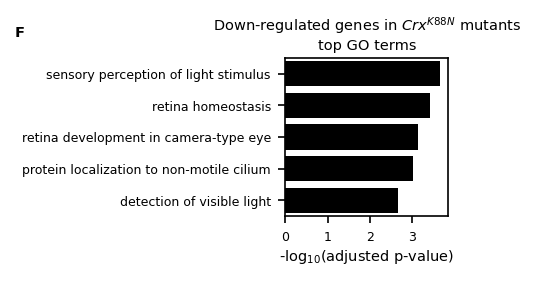

In [26]:
# Extended Data Fig.5 panel e. p10 k88n lost independent gene category GO enrichment barchart
file_name = os.path.join(rna_basedir, "gene.ontology", "p10.k88n.ind.lostGenes.tsv")
p10_k88n_indep_lost_df = pd.read_csv(file_name, sep="\t", header=0)

#p10_k88n_indep_lost_df = p10_k88n_indep_lost_df.iloc[[0,2,3,4,7,8],:]
p10_k88n_indep_lost_df = get_topN_GOterms(p10_k88n_indep_lost_df,top_n=5)
#display(p10_k88n_indep_lost_dff)

# convert padj to -log10 scale
p10_k88n_indep_lost_df["-log10padj"] = -np.log10(p10_k88n_indep_lost_df["p.adjust"])

# setup figure
fig, ax = plt.subplots(figsize=(1.4,1.4), dpi=150)
ax = sns.barplot(data=p10_k88n_indep_lost_df, x="-log10padj", y="Description", color="k", dodge=False, ax=ax)

ax.set_title(r"Down-regulated genes in $\itCrx^{K88N}$ mutants"+f"\ntop GO terms")
ax.set_xlabel("-$log_{10}$(adjusted p-value)")
ax.set_ylabel("")
ax.legend([],[],frameon=False) # remove legend

# add panel label
specseq_plot_utils.add_letter(ax, -1.6, 1.2, "F")

In [27]:
specseq_plot_utils.save_fig(fig, os.path.join(outbase_dir, "extended", "extended.figure5f.p10_k88n_independent_lostGenes.GObarchart"), timestamp=False, tight_layout=False)

### IV. Expression: RNA-seq in adult retina

### a. genes in the GO0009583 term: detection of light stimulus

In [39]:
# retrieve genelist of GO term 0009583: detection of light stimulus
light_stimulus_df = pd.read_csv(os.path.join(rna_basedir, "GO0009583_genelist.txt"), sep="\t", header=0, index_col=None)
# remove genes that are not relevant in photoreceptors
light_stimulus_df = light_stimulus_df.loc[lambda df: ~df[df.columns[0]].isin(["Sema5a","Sema5b","Fech","Opn3"]),:]
light_stimulus_genelist = light_stimulus_df.iloc[:,0].drop_duplicates()
light_stimulus_genelist.name = "gene"
del(light_stimulus_df)

# retireve the lfc of genes in the pathway
p21_rna_lfc = chip_rna_annotator.rna_fpm_filter(rna_compiled_counts, rna_compiled_lfc, age="p21", fpm_th=2).loc[:, lambda df: ["GENEID","gene"]+list(df.columns[df.columns.str.contains("p21")])]
p21_GO_genes = p21_rna_lfc.loc[lambda df: df.gene.isin(light_stimulus_genelist),:].copy().drop_duplicates("gene", keep="first").reset_index(drop=True)
print(f"total genes in the matrix: {len(p21_GO_genes.index)}")

# reorder columns/genotypes
order = list("p21."+pd.Series(["ehet","ehom","khet","khom","rhom"])+".lfc")
p21_GO_genes = p21_GO_genes.loc[:,order+ ["gene"]]#.set_index('gene')
# convert wide to long dataframe
data_to_plot = pd.melt(p21_GO_genes, id_vars=["gene"], value_vars=order, var_name="age", value_name="norm.counts")

total genes in the matrix: 48


Text(-0.2, 1.2, 'A')

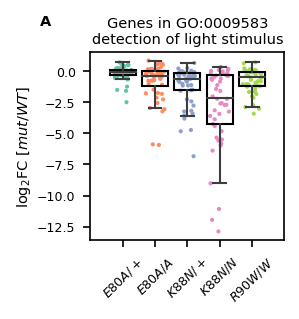

In [93]:
# Fig.5 panel a. boxplot and stripplot showing average gene expression changes of phototransduction genes
# set up the figure
fig = plt.figure(figsize=(1.8,2), constrained_layout=True, dpi=150)
gs = fig.add_gridspec(nrows=1, ncols=1, width_ratios=[1], height_ratios=[1])
gs.update(top=0.95,bottom=0.1,wspace=0.00,hspace=0.00) #padding for each grid space

ax = fig.add_subplot(gs[0])

plot_parameters = dict(
        xlabel = "",
        ylabel = f"$log_{2}$FC [$\itmut/WT$]",
        x_column="age",
        y_column="norm.counts",
        annot_bool=False,
        annot_pairs=list(itertools.combinations(order,2))
    )

fig, ax =  rnaseq_plot_utils.box_by_category(data=data_to_plot, **plot_parameters, morder=order, mpal={od:"k" for od in order}, patch_artist=False, figax=(fig,ax))
ax = sns.stripplot(x="age", y=f"norm.counts", data=data_to_plot, palette="Set2", dodge=False, edgecolor="none", linewidth=1, marker=".", size=4, jitter=.3, ax=ax, zorder=0)

ax.set_xlim(-1,5)
ax.set_xticks(range(5))
ax.set_xticklabels([f"$\it{name}$" for name in ["E80A/+", "E80A/A", "K88N/+", "K88N/N", "R90W/W"]], rotation=45)
ax.set_xlabel("")
ax.set_ylabel(f"$log_{2}$FC [$\itmut/WT$]")
ax.set_title("Genes in GO:0009583\ndetection of light stimulus")

# add panel label
specseq_plot_utils.add_letter(ax, -.2, 1.2, "A")

In [94]:
specseq_plot_utils.save_fig(fig, os.path.join(outbase_dir, "manuscript", "figure5a_p21_GO0009583_box.nostats"), tight_layout=False, timestamp=False)

Text(-0.2, 1.24, 'A')

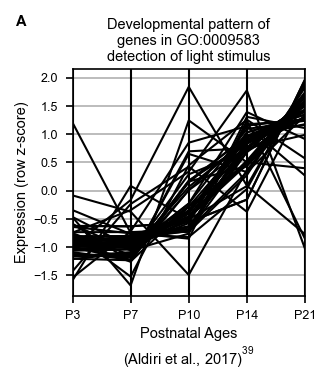

In [40]:
# developmental pattern of genes in GO term
data_to_plot = clean_aldiri_rowz.loc[lambda df: df.index.isin(p21_GO_genes.gene),:].copy().reset_index(drop=False)

# set up the figure
fig, ax = plt.subplots(figsize=(2,2), dpi=150)

# make the parallel coordinated plot
pd.plotting.parallel_coordinates(data_to_plot, class_column="gene", color=["k"]*len(data_to_plot.index), ax=ax)

# decoration
ax.set_xticklabels(["P3","P7","P10","P14","P21"])
ax.set(title="Developmental pattern of\ngenes in GO:0009583\ndetection of light stimulus", xlabel="Postnatal Ages\n(Aldiri et al., 2017)"+r"$^{39}$", ylabel="Expression (row z-score)")
# remove legend
ax.get_legend().remove()

# add panel label
specseq_plot_utils.add_letter(ax, -.2, 1.24, "A")

In [41]:
specseq_plot_utils.save_fig(fig, os.path.join(outbase_dir, "extended", "extended.figure7a_GO0009583.dev.zscore"), tight_layout=False, timestamp=False)

### b. expression heatmap of phototransduction genes in both rod and cone

In [44]:
photoTrans_genes = pd.DataFrame(["Rho","Opn1sw","Opn1mw","Gnat1","Gnb1","Gngt1","Gnb3","Gnat2","Gngt2","Pde6a","Pde6b","Pde6g","Pde6c","Pde6h", "Rdh8", "Rdh11", "Rdh12", "retSDR1", "Cngb1","Cnga1","Cnga3","Cngb3", "Abca4", "Arr3","Sag","Rcvrn","Guca1b","Guca1a"], columns=["gene"])

In [45]:
p21_photoTrans_genes = p21_rna_lfc.loc[lambda df: df.gene.isin(photoTrans_genes["gene"]),:].copy().dropna(axis="index", how="any")
# re order as in the genelist
p21_photoTrans_genes = pd.merge(photoTrans_genes, p21_photoTrans_genes, how="inner").drop_duplicates("gene", keep="first")


Text(-0.2, 1.2, 'B')

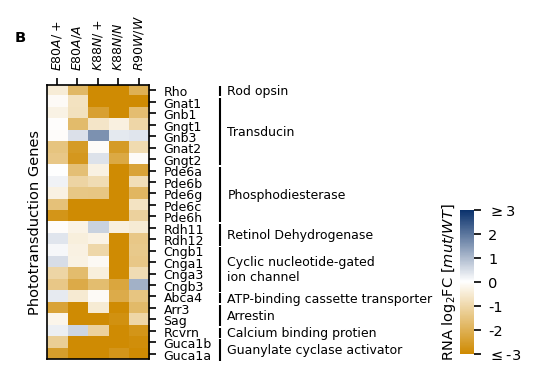

In [48]:
# Fig.5 panel b. heatmap showing expression change of selected phototransduction genes

# set up the figrue
fig = plt.figure(figsize=(3.1,2.4), constrained_layout=True, dpi=150)
gs = fig.add_gridspec(nrows=1, ncols=3, width_ratios=[1.2,2,1], height_ratios=[1])
gs.update(top=0.95,bottom=0.1,wspace=0.00,hspace=0.00) #padding for each grid space

#add gene lables on right side of the heatmap
line_left = .44
text_axes = []
bottom = .02
height = .032
for h in [2,1,2,1,4,2,5,6,1]:
    new_ax = plt.axes([line_left, bottom, 0.03, height*h-0.005])
    text_axes.append(new_ax)
    bottom += height*h

for ax,text in zip(text_axes,["Guanylate cyclase activator", "Calcium binding protien", "Arrestin", "ATP-binding cassette transporter", "Cyclic nucleotide-gated\nion channel", "Retinol Dehydrogenase", "Phosphodiesterase", "Transducin", "Rod opsin"]):
    ax.axis("off")
    ax.axvline(x=-1, color='black', linestyle='-')
    ax.text(1, .5, text, fontsize=mpl.rcParams["legend.fontsize"], va="center", ha="left", transform=ax.transAxes)

ax = fig.add_subplot(gs[0])
# reorder the dataframe by genotype
order = list("p21."+pd.Series(["ehet","ehom","khet","khom","rhom"])+".lfc")
data_to_plot = p21_photoTrans_genes.loc[:,order+["gene"]].set_index('gene')

heatmap = ax.imshow(data_to_plot, aspect="auto", vmin=-3, vmax=3, cmap=div_heat_colors)
ax.xaxis.tick_top()
ax.yaxis.tick_right()
    
ax.set_yticks(np.arange(len(data_to_plot.index)))
ax.set_yticklabels(data_to_plot.index, ha="left")
ax.set_xticks(np.arange(len(data_to_plot.columns)))
ax.set_xticklabels([f"$\it{name}$" for name in ["E80A/+", "E80A/A", "K88N/+", "K88N/N", "R90W/W"]], rotation=90)
ax.set_ylabel("Phototransduction Genes")

# add color bar separately
cbar_ax = plt.axes([.97, .04, 0.03, 0.4])
cbar_ax.set_frame_on(False)
norm = mpl.colors.Normalize(vmin=-3, vmax=3)
colorbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=div_heat_colors), ticks=[-3,-2,-1,0,1,2,3],
        cax=cbar_ax, orientation='vertical')
ticks = cbar_ax.get_yticks()
ticks = [f"{i:.0f}" for i in ticks]
ticks[-1] = r"$\geq$" + ticks[-1]
ticks[0] = r"$\leq$" + ticks[0]
cbar_ax.set_yticklabels(ticks)
cbar_ax.text(-.1,0, f"RNA $log_{2}$FC [$\itmut/WT$]", rotation=90, fontsize=mpl.rcParams['axes.titlesize'], va="center", ha="right")
cbar_ax.tick_params(labelsize=7, rotation=0)

# add panel label
specseq_plot_utils.add_letter(ax, -.2, 1.2, "B")

In [79]:
specseq_plot_utils.save_fig(fig, os.path.join(outbase_dir, "manuscript", "figure5a_p21_photoTransGenes"), tight_layout=False, timestamp=False)

Text(-0.4, 1.2, 'B')

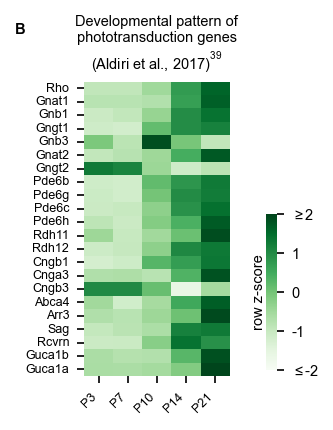

In [46]:
fig, ax_list = plt.subplots(ncols=2, figsize=(1.8,2.6), dpi=150, constrained_layout=False, gridspec_kw=dict(width_ratios=[1,.4], wspace=.05))

data_to_plot = clean_aldiri_rowz.loc[lambda df: df.index.isin(p21_photoTrans_genes.gene),:].copy().reset_index(drop=False)
# re order as in the genelist
data_to_plot = pd.merge(p21_photoTrans_genes, data_to_plot, how="inner").drop_duplicates("gene", keep="first")

hm_ax = ax_list[0]
hm_ax = sns.heatmap(data=data_to_plot.loc[:,["p3","p7","p10","p14","p21"]], ax=hm_ax, cmap="Greens", vmin=-2, vmax=2, cbar=False, yticklabels=data_to_plot.gene)
hm_ax.set_xticklabels([str.upper(age) for age in ["p3","p7","p10","p14","p21"]], rotation=45, ha="right", va="top")
hm_ax.set_title("Developmental pattern of\nphototransduction genes\n(Aldiri et al., 2017)"+r"$^{39}$", pad=6)


# add color bar
ax_list[1].axis("off")
cbar_ax = plt.axes([0.8, .14, 0.04, 0.4])
cbar_ax.set_frame_on(False)
norm = mpl.colors.Normalize(vmin=-2, vmax=2)
colorbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="Greens"), ticks=[-2,-1,0,1,2],
        cax=cbar_ax, orientation='vertical')
ticks = cbar_ax.get_yticks()
ticks = [f"{i:.0f}" for i in ticks]
ticks[-1] = r"$\geq$" + ticks[-1]
ticks[0] = r"$\leq$" + ticks[0]
cbar_ax.set_yticklabels(ticks)
cbar_ax.tick_params(labelsize=7, rotation=0)
cbar_ax.text(0,0, "row z-score", rotation=90, fontsize=7, va="center", ha="right")

# add panel label
specseq_plot_utils.add_letter(hm_ax, -.4, 1.2, "B")

In [47]:
specseq_plot_utils.save_fig(fig, os.path.join(outbase_dir, "extended", "extended.figure7b_photoTransGenes.dev.zscore"), tight_layout=False, timestamp=False)

### V. HD motif logos

In [146]:
for i,name in enumerate(["wt_olap.DREME.1", "e80a_olap.DREME.1", "k88n_olap.DREME.1"]):
    fig, pwm_ax = plt.subplots(figsize=(.8,.3), dpi=300)
    #pwm_ax.axis("off")
    pwm_ax.set_frame_on(False)
    pwm = hdmuts_meme_pwms[name].copy()
    if "k88n" in name: # plot reverse complement for k88n
        pwm = specseq_ewm_utils.get_motif_revcomp(pwm)
    fig, pwm_ax, pwm_logo = specseq_plot_utils.make_pwm_logo(pwm, sequence_design=None, add_filler=False, figax=(fig, pwm_ax))
    pwm_ax.set_ylim(bottom=0, top=2.4)
    pwm_ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    pwm_ax.xaxis.set_visible(False)
    pwm_ax.yaxis.set_visible(False)
    [s.set_visible(False) for s in pwm_ax.spines.values()]
    plt.close()

    specseq_plot_utils.save_fig(fig, os.path.join(outbase_dir, "pwm_logos", name), timestamp=False, tight_layout=False)

    